In [176]:
from pygeoinf.interval import ( Lebesgue, IntervalDomain, LebesgueIntegrationConfig,
                              IntegrationConfig, ParallelConfig, LebesgueSpaceDirectSum,
                              SOLAOperator, Function, BoundaryConditions, Laplacian,
                              BesselSobolevInverse, KLSampler)
from pygeoinf.interval.function_providers import NormalModesProvider, BumpFunctionProvider, NullFunctionProvider
from pygeoinf import ( EuclideanSpace, RowLinearOperator, GaussianMeasure,
                      LinearForwardProblem, LinearBayesianInference, CholeskySolver,
                       HilbertSpaceDirectSum, LinearOperator, LinearForm )
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Set-up folder for saving figures
import os
figures_folder = 'example_1'
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)

In [177]:
# =============================================================================
# INTEGRATION AND PARALLELIZATION CONFIGURATION
# =============================================================================

# Configure integration methods for Lebesgue spaces
# These settings control how inner products, dual pairings, and general integrals are computed
Lebesgue_integration_cfg = LebesgueIntegrationConfig(
    inner_product=IntegrationConfig(method='simpson', n_points=1000),
    dual=IntegrationConfig(method='simpson', n_points=1000),
    general=IntegrationConfig(method='simpson', n_points=1000)
)

# Configure integration for Laplacian spectral operators
# Higher accuracy is often needed for eigenvalue problems
laplacian_integration_cfg = IntegrationConfig(method='simpson', n_points=1000)

# Configure integration for SOLA operators
sola_integration_cfg = IntegrationConfig(method='simpson', n_points=1000)

# Configure parallelization
# Set enabled=True to use parallel processing for expensive operations
# n_jobs: number of parallel workers (-1 uses all available cores)
parallel_cfg = ParallelConfig(enabled=True, n_jobs=16)

# Alternative: more granular parallelization control for Lebesgue spaces
# Lebesgue_parallel_cfg = LebesgueParallelConfig(
#     inner_product=ParallelConfig(enabled=True, n_jobs=4),
#     dual=ParallelConfig(enabled=True, n_jobs=4),
#     general=ParallelConfig(enabled=True, n_jobs=4)
# )

In [178]:
# =============================================================================
# CONFIGURATION FLAGS
# =============================================================================

# Set to True to compute and visualize the model posterior
# Set to False to skip model posterior and go directly to property posterior
COMPUTE_MODEL_POSTERIOR = True

print(f"Configuration:")
print(f"  COMPUTE_MODEL_POSTERIOR = {COMPUTE_MODEL_POSTERIOR}")
if COMPUTE_MODEL_POSTERIOR:
    print("  → Will compute model posterior, then push to property space")
else:
    print("  → Will skip model posterior and compute property posterior directly")
    print("  → Expected speedup: ~4-5x faster")

Configuration:
  COMPUTE_MODEL_POSTERIOR = True
  → Will compute model posterior, then push to property space


In [179]:
# Create a function domain and spaces
function_domain = IntervalDomain(0, 1)

# We create a model space for vp and another for vs and another for rho
N = 100  # number of basis functions
M_vp = Lebesgue(N, function_domain, basis='sine',
                integration_config=Lebesgue_integration_cfg.inner_product,
                parallel_config=parallel_cfg)  # model space
M_vs = Lebesgue(N, function_domain, basis='sine',
                integration_config=Lebesgue_integration_cfg.inner_product,
                parallel_config=parallel_cfg)  # model space
M_rho = Lebesgue(N, function_domain, basis='sine',
                 integration_config=Lebesgue_integration_cfg.inner_product,
                 parallel_config=parallel_cfg)  # model space

# We also create models spaces for discontinuity physical parameters

M_sigma_0 = EuclideanSpace(1)  # model space for sigma_0
M_sigma_1 = EuclideanSpace(1)  # model space for sigma_1


# And we take their direct sum
M_functions = LebesgueSpaceDirectSum([M_vp, M_vs, M_rho])
M_euclidean = HilbertSpaceDirectSum([M_sigma_0, M_sigma_1])
M_model = HilbertSpaceDirectSum([M_functions, M_euclidean])

N_d = 50 # number of data points
D = EuclideanSpace(N_d) # data space
N_p = 20 # number of property points
P = EuclideanSpace(N_p) # property space

In [180]:
# Create forward and property mappings
width = 0.2 # width of the bump target functions
centers = np.linspace(function_domain.a + width / 2, function_domain.b - width / 2, N_p) # centers of the bumps
# Create a normal modes provider for the forward operator
# and a bump function provider for the target operator
# Note: The random_state is set to ensure reproducibility of results
normal_modes_provider_vp = NormalModesProvider(
        M_vs,
        n_modes_range=(1, 50),
        coeff_range=(-5, 5),
        gaussian_width_percent_range=(1, 5),
        freq_range=(0.1, 20),
        random_state=2,
    )
normal_modes_provider_vs = NormalModesProvider(
        M_vs,
        n_modes_range=(1, 50),
        coeff_range=(-5, 5),
        gaussian_width_percent_range=(1, 5),
        freq_range=(0.1, 20),
        random_state=3,
    )
normal_models_provider_rho = NormalModesProvider(
        M_rho,
        n_modes_range=(1, 50),
        coeff_range=(-5, 5),
        gaussian_width_percent_range=(1, 5),
        freq_range=(0.1, 20),
        random_state=4,
    )
K_sigma_0 = np.ones(N_d) + np.random.rand(N_d)  # scaling factor for sigma_0
K_sigma_1 = np.ones(N_d) + np.random.rand(N_d)  # scaling factor for sigma_1

# Create SOLA forward operators
G_vp = SOLAOperator(M_vp, D, normal_modes_provider_vp, integration_config=sola_integration_cfg)
G_vs = SOLAOperator(M_vs, D, normal_modes_provider_vs, integration_config=sola_integration_cfg)
G_rho = SOLAOperator(M_rho, D, normal_models_provider_rho, integration_config=sola_integration_cfg)
G_sigma_0 = LinearOperator(M_sigma_0, D, lambda x: K_sigma_0 * x)
G_sigma_1 = LinearOperator(M_sigma_1, D, lambda x: K_sigma_1 * x)

# We combine the three forward operators into one mapping from the direct sum space
G_functions = RowLinearOperator([G_vp, G_vs, G_rho])
G_euclidean = RowLinearOperator([G_sigma_0, G_sigma_1])
G = RowLinearOperator([G_functions, G_euclidean])
# Now we create targets for each property
target_provider_vp = BumpFunctionProvider(M_vp, centers=centers, default_width=width)
target_provider_vs = NullFunctionProvider(M_vs)  # No target for vs
target_provider_rho = NullFunctionProvider(M_rho)  # No target for rho
# Create SOLA property operators
T_vp = SOLAOperator(M_vp, P, target_provider_vp, integration_config=sola_integration_cfg)
T_vs = SOLAOperator(M_vs, P, target_provider_vs, integration_config=sola_integration_cfg)
T_rho = SOLAOperator(M_rho, P, target_provider_rho, integration_config=sola_integration_cfg)
T_sigma_0 = LinearOperator(M_sigma_0, P, lambda x: np.zeros(N_p))
T_sigma_1 = LinearOperator(M_sigma_1, P, lambda x: np.zeros(N_p))
# And we combine them into one property operator from the direct sum space
T_functions = RowLinearOperator([T_vp, T_vs, T_rho])
T_euclidean = RowLinearOperator([T_sigma_0, T_sigma_1])
T = RowLinearOperator([T_functions, T_euclidean])

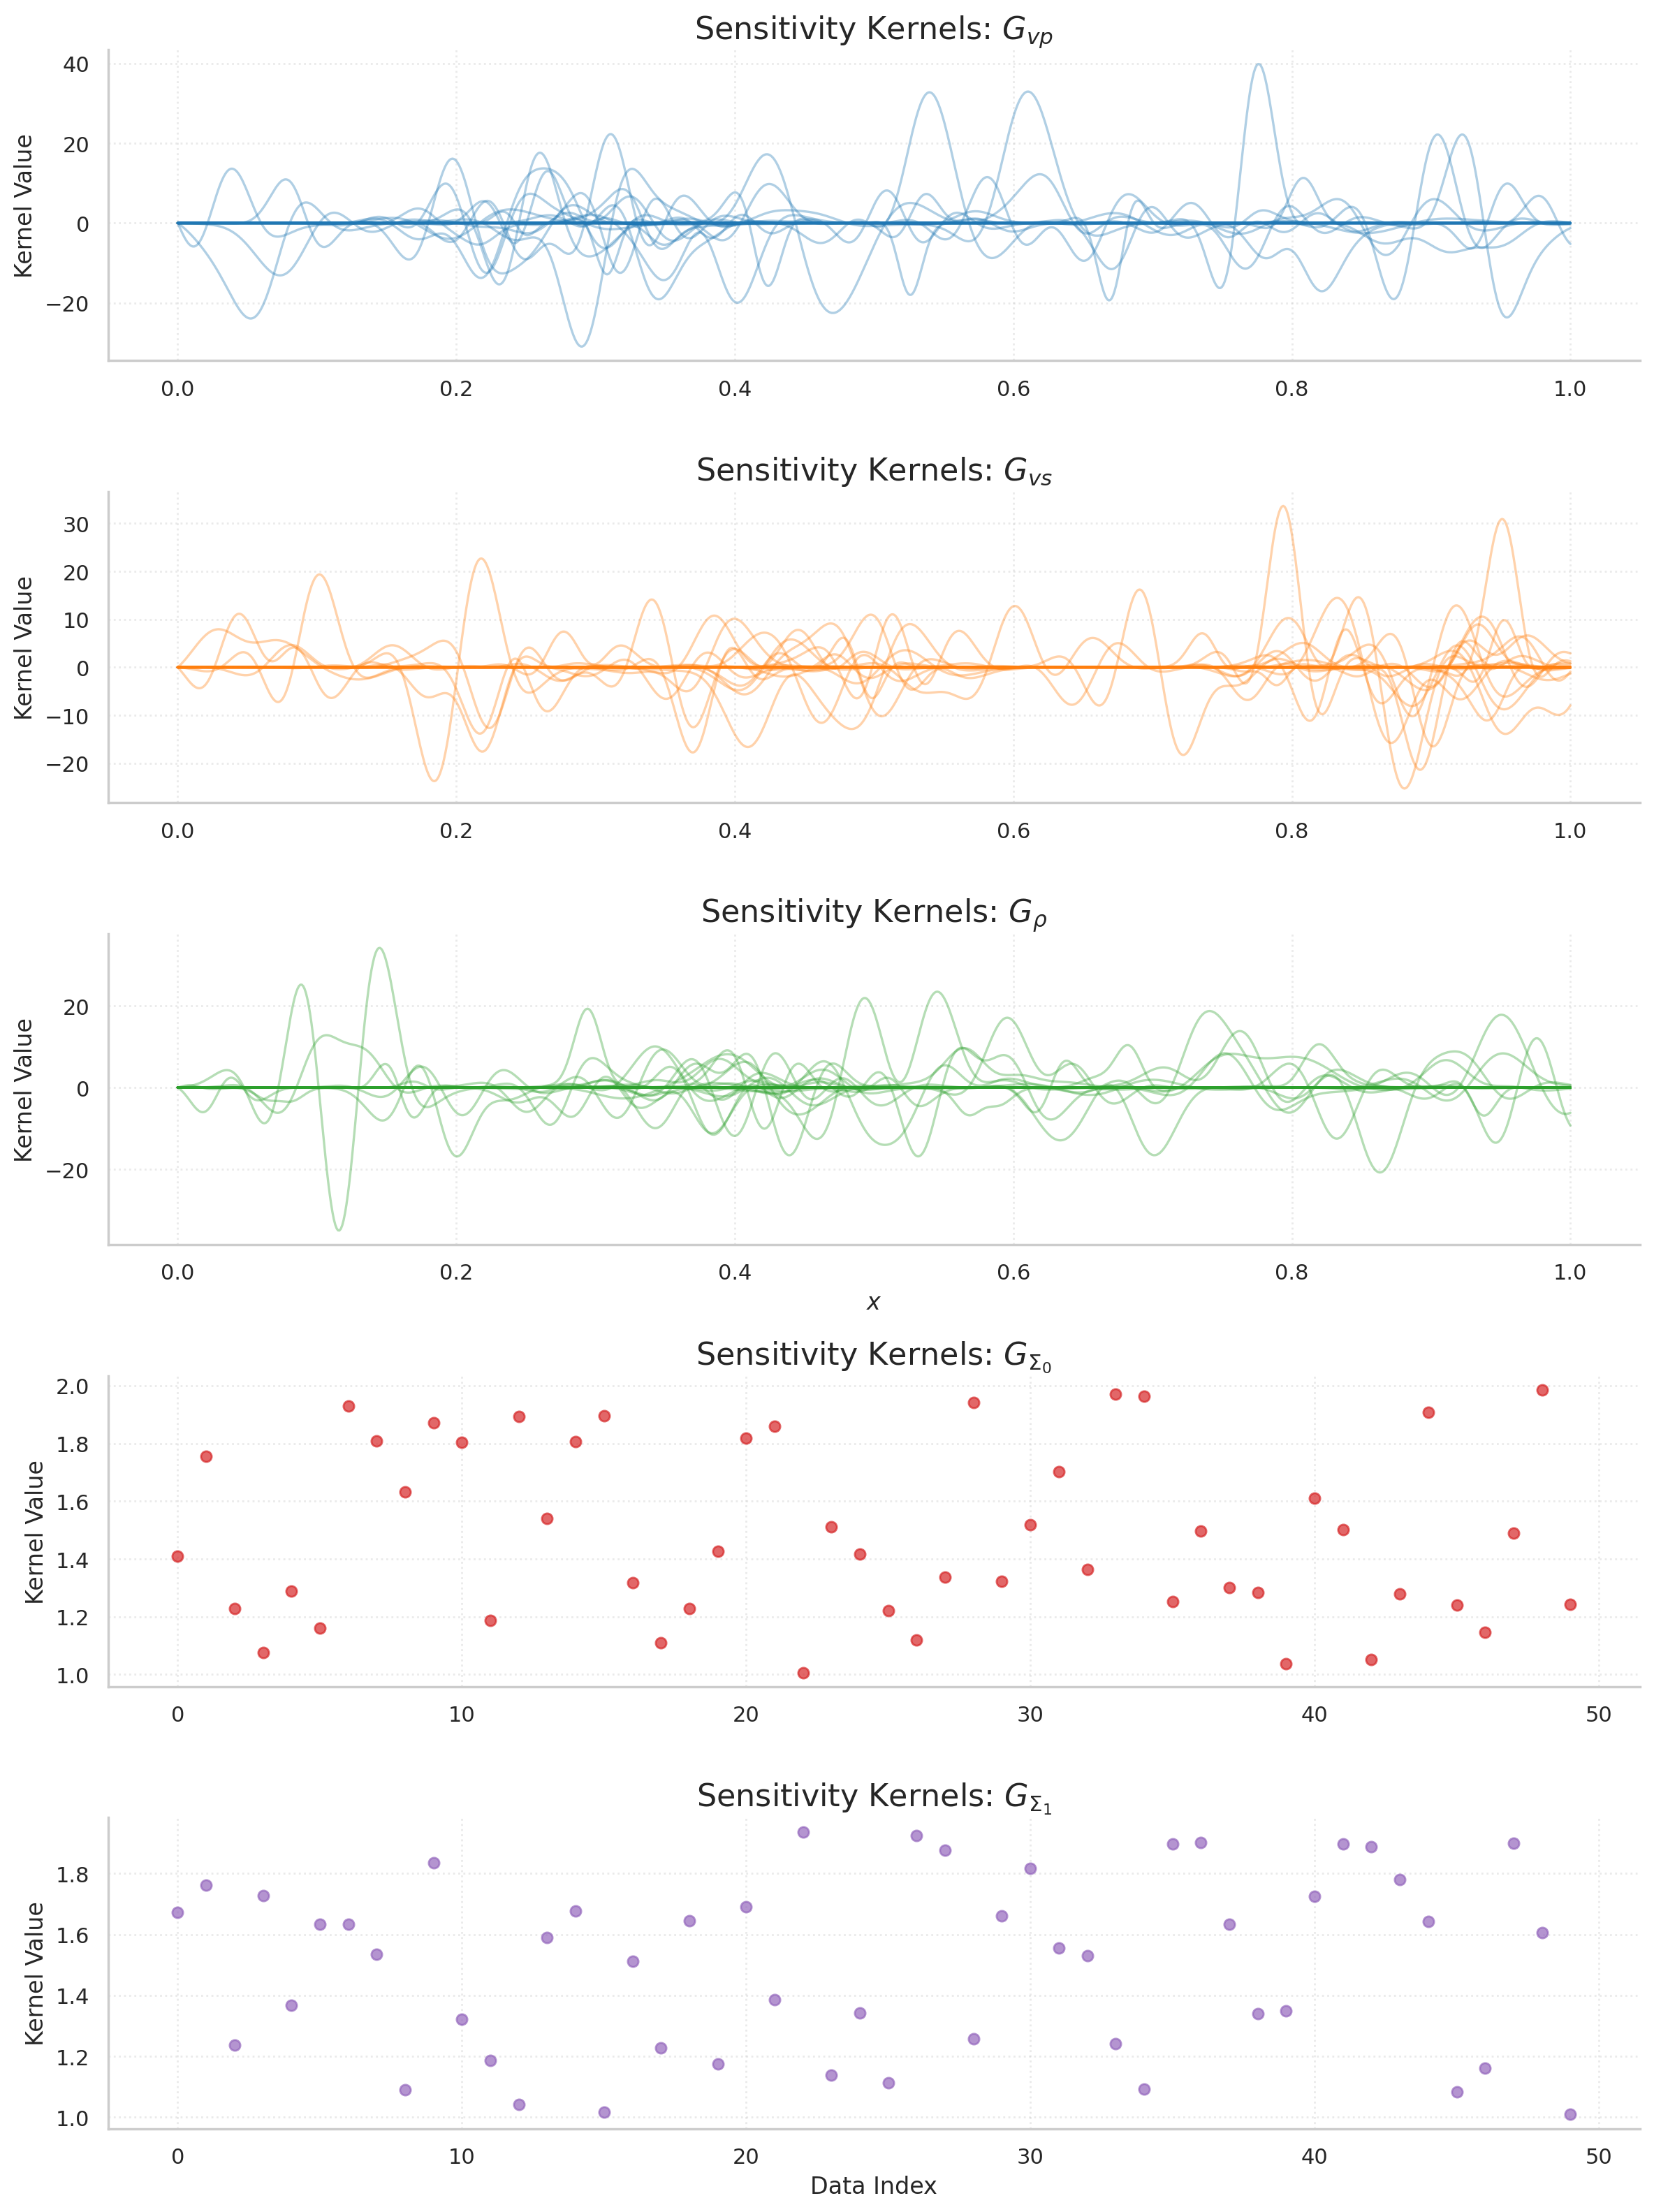

In [181]:
# Sensitivity Kernels figure
fig_title = "Sensitivity Kernels (vp & vs & rho)"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

x = np.linspace(function_domain.a, function_domain.b, 1000)

sns.set_theme(style="whitegrid", palette="muted", color_codes=True)

# Create figure with 5 subplots
fig = plt.figure(figsize=(12, 16), dpi=200)

# First 3 subplots share x-axis
ax1 = plt.subplot(5, 1, 1)
ax2 = plt.subplot(5, 1, 2, sharex=ax1)
ax3 = plt.subplot(5, 1, 3, sharex=ax1)

# Bottom 2 subplots share a different x-axis
ax4 = plt.subplot(5, 1, 4)
ax5 = plt.subplot(5, 1, 5, sharex=ax4)

axs = [ax1, ax2, ax3, ax4, ax5]

# Top subplot: G_vp kernels
axs[0].set_title(r"Sensitivity Kernels: $G_{vp}$", fontsize=16)
for i in range(N_d):
    axs[0].plot(
        x,
        G_vp.get_kernel(i).evaluate(x),
        color='tab:blue',
        alpha=0.35,
        linewidth=1.2,
    )
axs[0].set_ylabel("Kernel Value", fontsize=12)
axs[0].grid(True, linestyle=':', alpha=0.4)

# Second subplot: G_vs kernels
axs[1].set_title(r"Sensitivity Kernels: $G_{vs}$", fontsize=16)
for i in range(N_d):
    axs[1].plot(
        x,
        G_vs.get_kernel(i).evaluate(x),
        color='tab:orange',
        alpha=0.35,
        linewidth=1.2,
    )
axs[1].set_ylabel("Kernel Value", fontsize=12)
axs[1].grid(True, linestyle=':', alpha=0.4)

# Third subplot: G_rho kernels
axs[2].set_title(r"Sensitivity Kernels: $G_{\rho}$", fontsize=16)
for i in range(N_d):
    axs[2].plot(
        x,
        G_rho.get_kernel(i).evaluate(x),
        color='tab:green',
        alpha=0.35,
        linewidth=1.2,
    )
axs[2].set_xlabel(r"$x$", fontsize=12)
axs[2].set_ylabel("Kernel Value", fontsize=12)
axs[2].grid(True, linestyle=':', alpha=0.4)

# Fourth subplot: G_sigma_0 kernels
axs[3].set_title(r"Sensitivity Kernels: $G_{\Sigma_0}$", fontsize=16)
axs[3].scatter(
    np.arange(N_d),
    K_sigma_0,
    color='tab:red',
    alpha=0.7,
    s=30,
)
axs[3].set_ylabel("Kernel Value", fontsize=12)
axs[3].grid(True, linestyle=':', alpha=0.4)

# Fifth subplot: G_sigma_1 kernels
axs[4].set_title(r"Sensitivity Kernels: $G_{\Sigma_1}$", fontsize=16)
axs[4].scatter(
    np.arange(N_d),
    K_sigma_1,
    color='tab:purple',
    alpha=0.7,
    s=30,
)
axs[4].set_xlabel(r"Data Index", fontsize=12)
axs[4].set_ylabel("Kernel Value", fontsize=12)
axs[4].grid(True, linestyle=':', alpha=0.4)

sns.despine()
plt.tight_layout()

# Save as both PNG and PDF for publication
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()


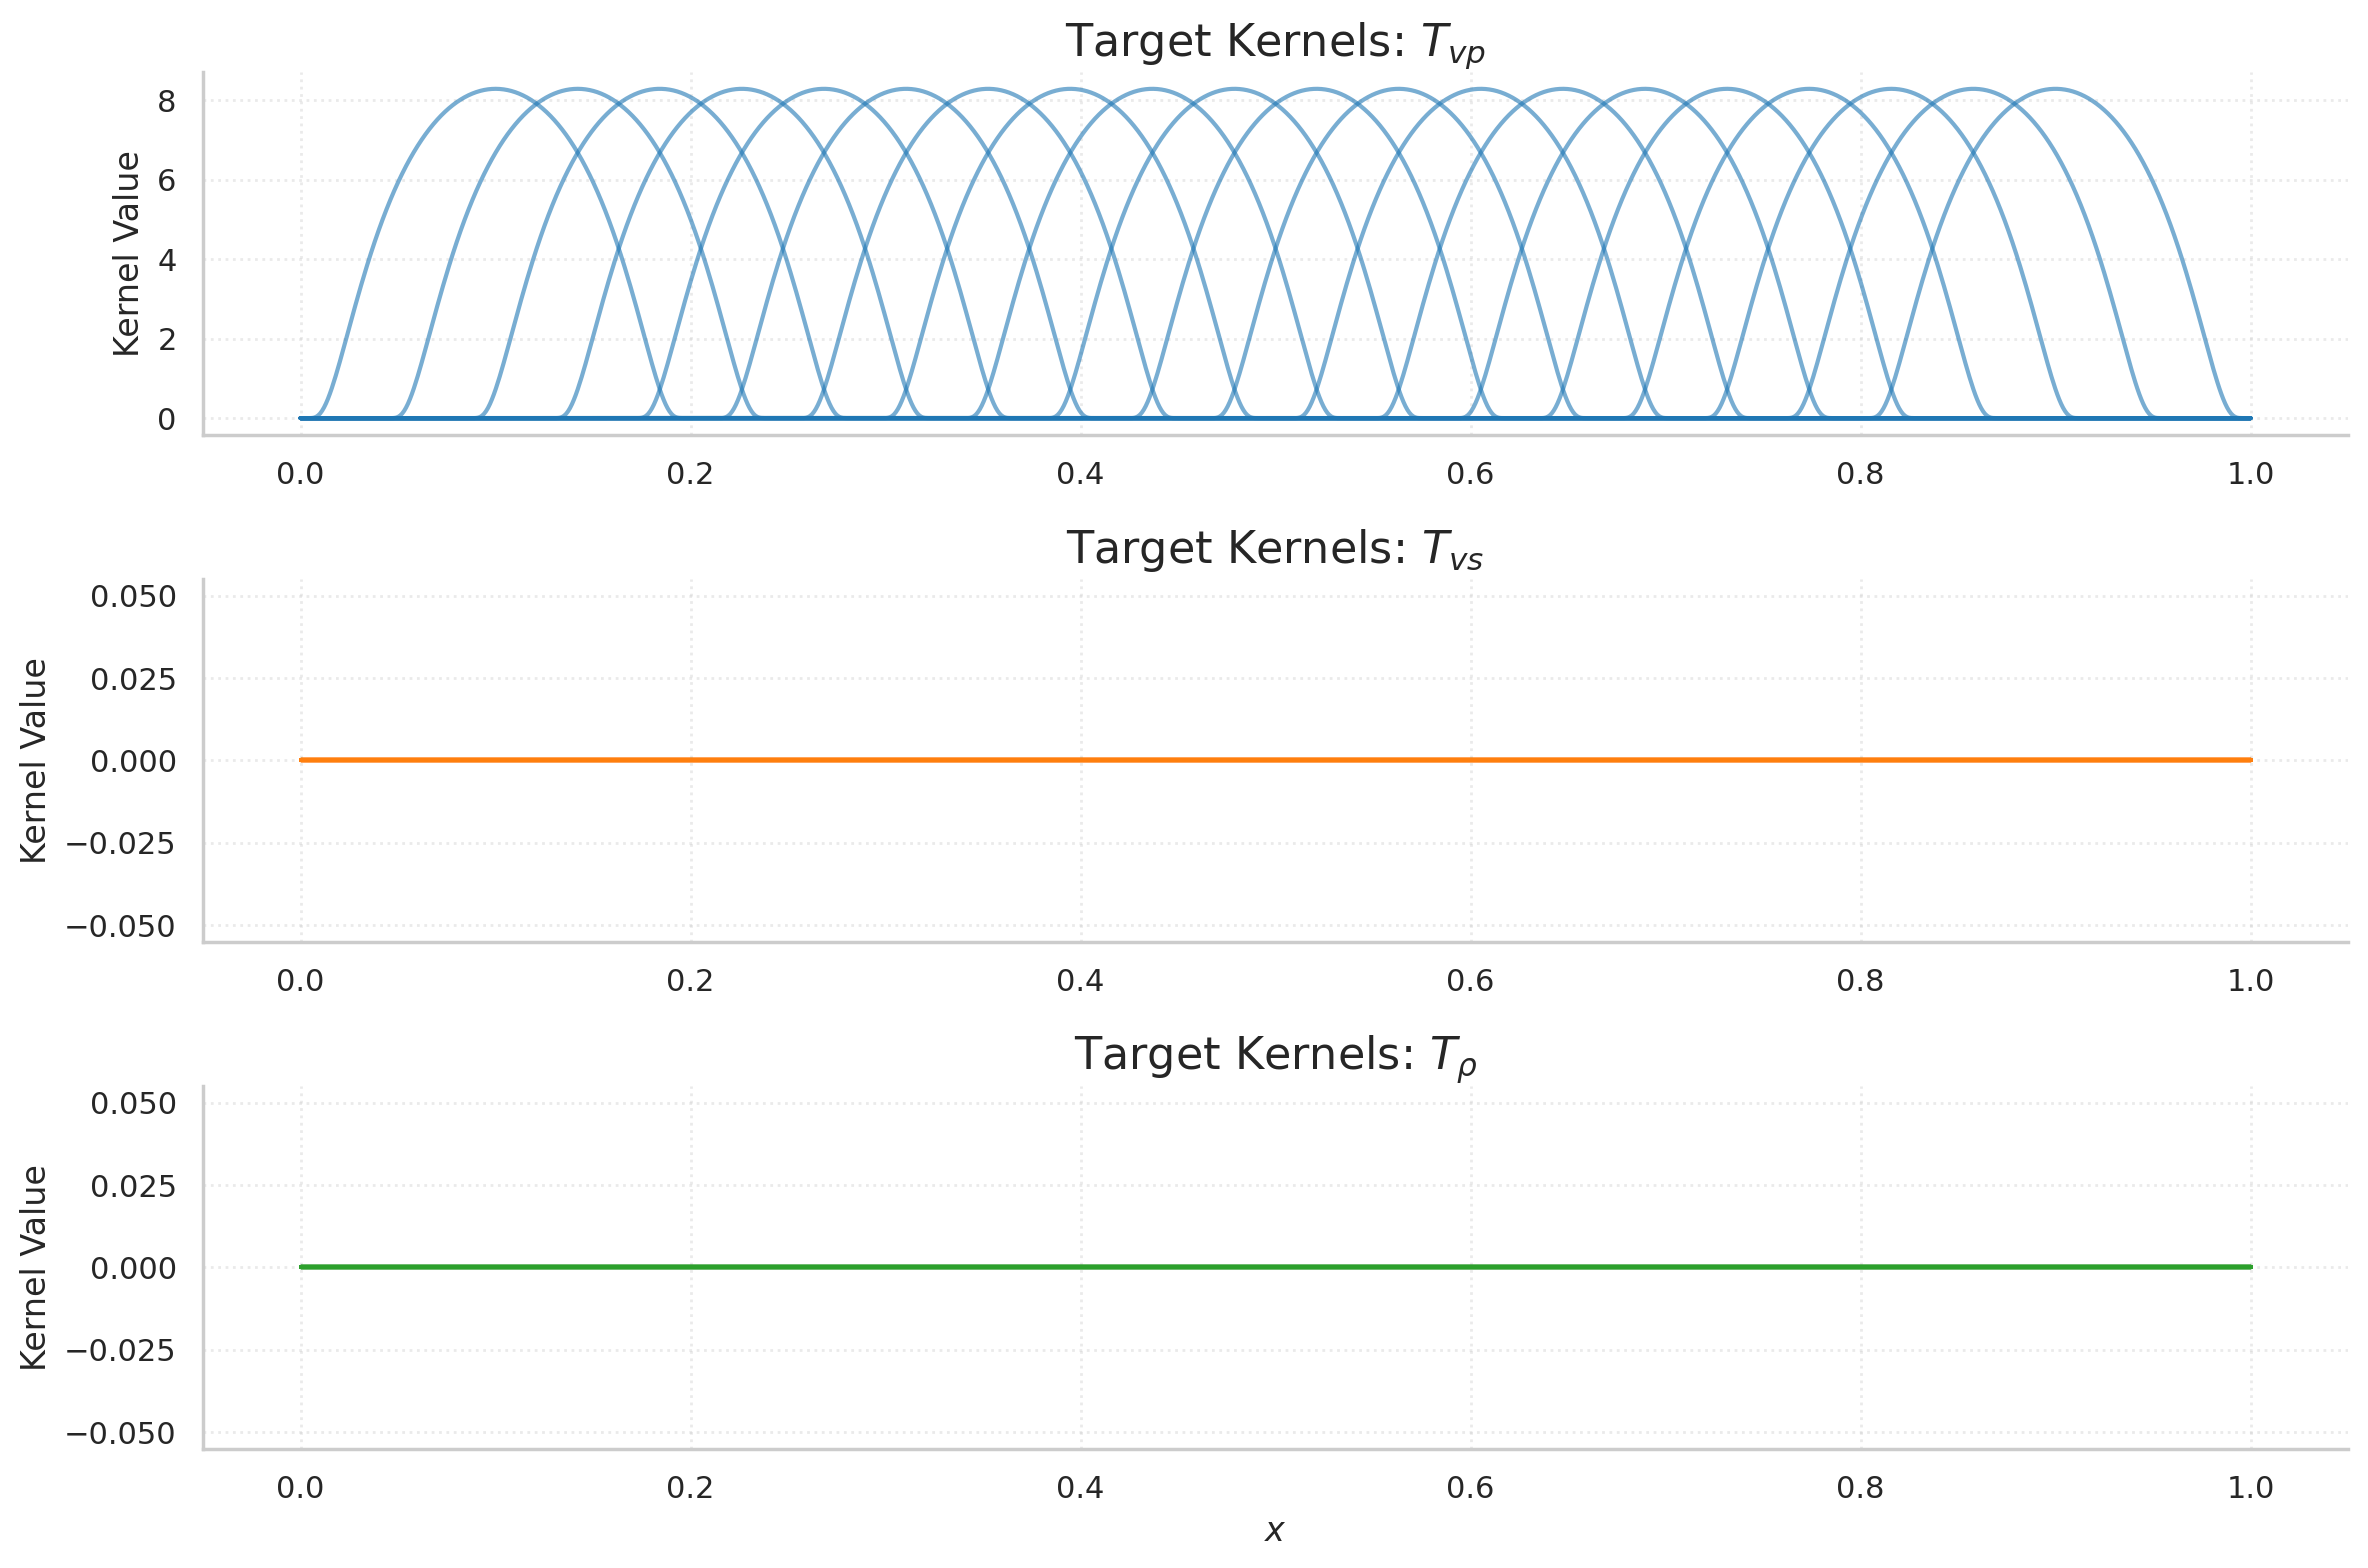

In [182]:
# Target Kernels figure (vp & vs & rho)
fig_title = "Target Kernels (vp & vs & rho)"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

x = np.linspace(function_domain.a, function_domain.b, 1000)

sns.set_theme(style="whitegrid", palette="muted", color_codes=True)

# Create figure with 3 subplots sharing x-axis
fig = plt.figure(figsize=(12, 8), dpi=200)

# All 3 subplots share x-axis (function space target operators)
ax1 = plt.subplot(3, 1, 1)
ax2 = plt.subplot(3, 1, 2, sharex=ax1)
ax3 = plt.subplot(3, 1, 3, sharex=ax1)

axs = [ax1, ax2, ax3]

# Top: T_vp
axs[0].set_title(r"Target Kernels: $T_{vp}$", fontsize=16)
for i in range(N_p):
    axs[0].plot(
        x,
        T_vp.get_kernel(i).evaluate(x),
        color='tab:blue',
        alpha=0.6,
        linewidth=1.5,
    )
axs[0].set_ylabel("Kernel Value", fontsize=12)
axs[0].grid(True, linestyle=':', alpha=0.4)

# Middle: T_vs
axs[1].set_title(r"Target Kernels: $T_{vs}$", fontsize=16)
for i in range(N_p):
    axs[1].plot(
        x,
        T_vs.get_kernel(i).evaluate(x),
        color='tab:orange',
        alpha=0.6,
        linewidth=1.5,
    )
axs[1].set_ylabel("Kernel Value", fontsize=12)
axs[1].grid(True, linestyle=':', alpha=0.4)

# Bottom: T_rho
axs[2].set_title(r"Target Kernels: $T_{\rho}$", fontsize=16)
for i in range(N_p):
    axs[2].plot(
        x,
        T_rho.get_kernel(i).evaluate(x),
        color='tab:green',
        alpha=0.6,
        linewidth=1.5,
    )
axs[2].set_xlabel(r"$x$", fontsize=12)
axs[2].set_ylabel("Kernel Value", fontsize=12)
axs[2].grid(True, linestyle=':', alpha=0.4)

sns.despine()
plt.tight_layout()

# Save as both PNG and PDF
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()


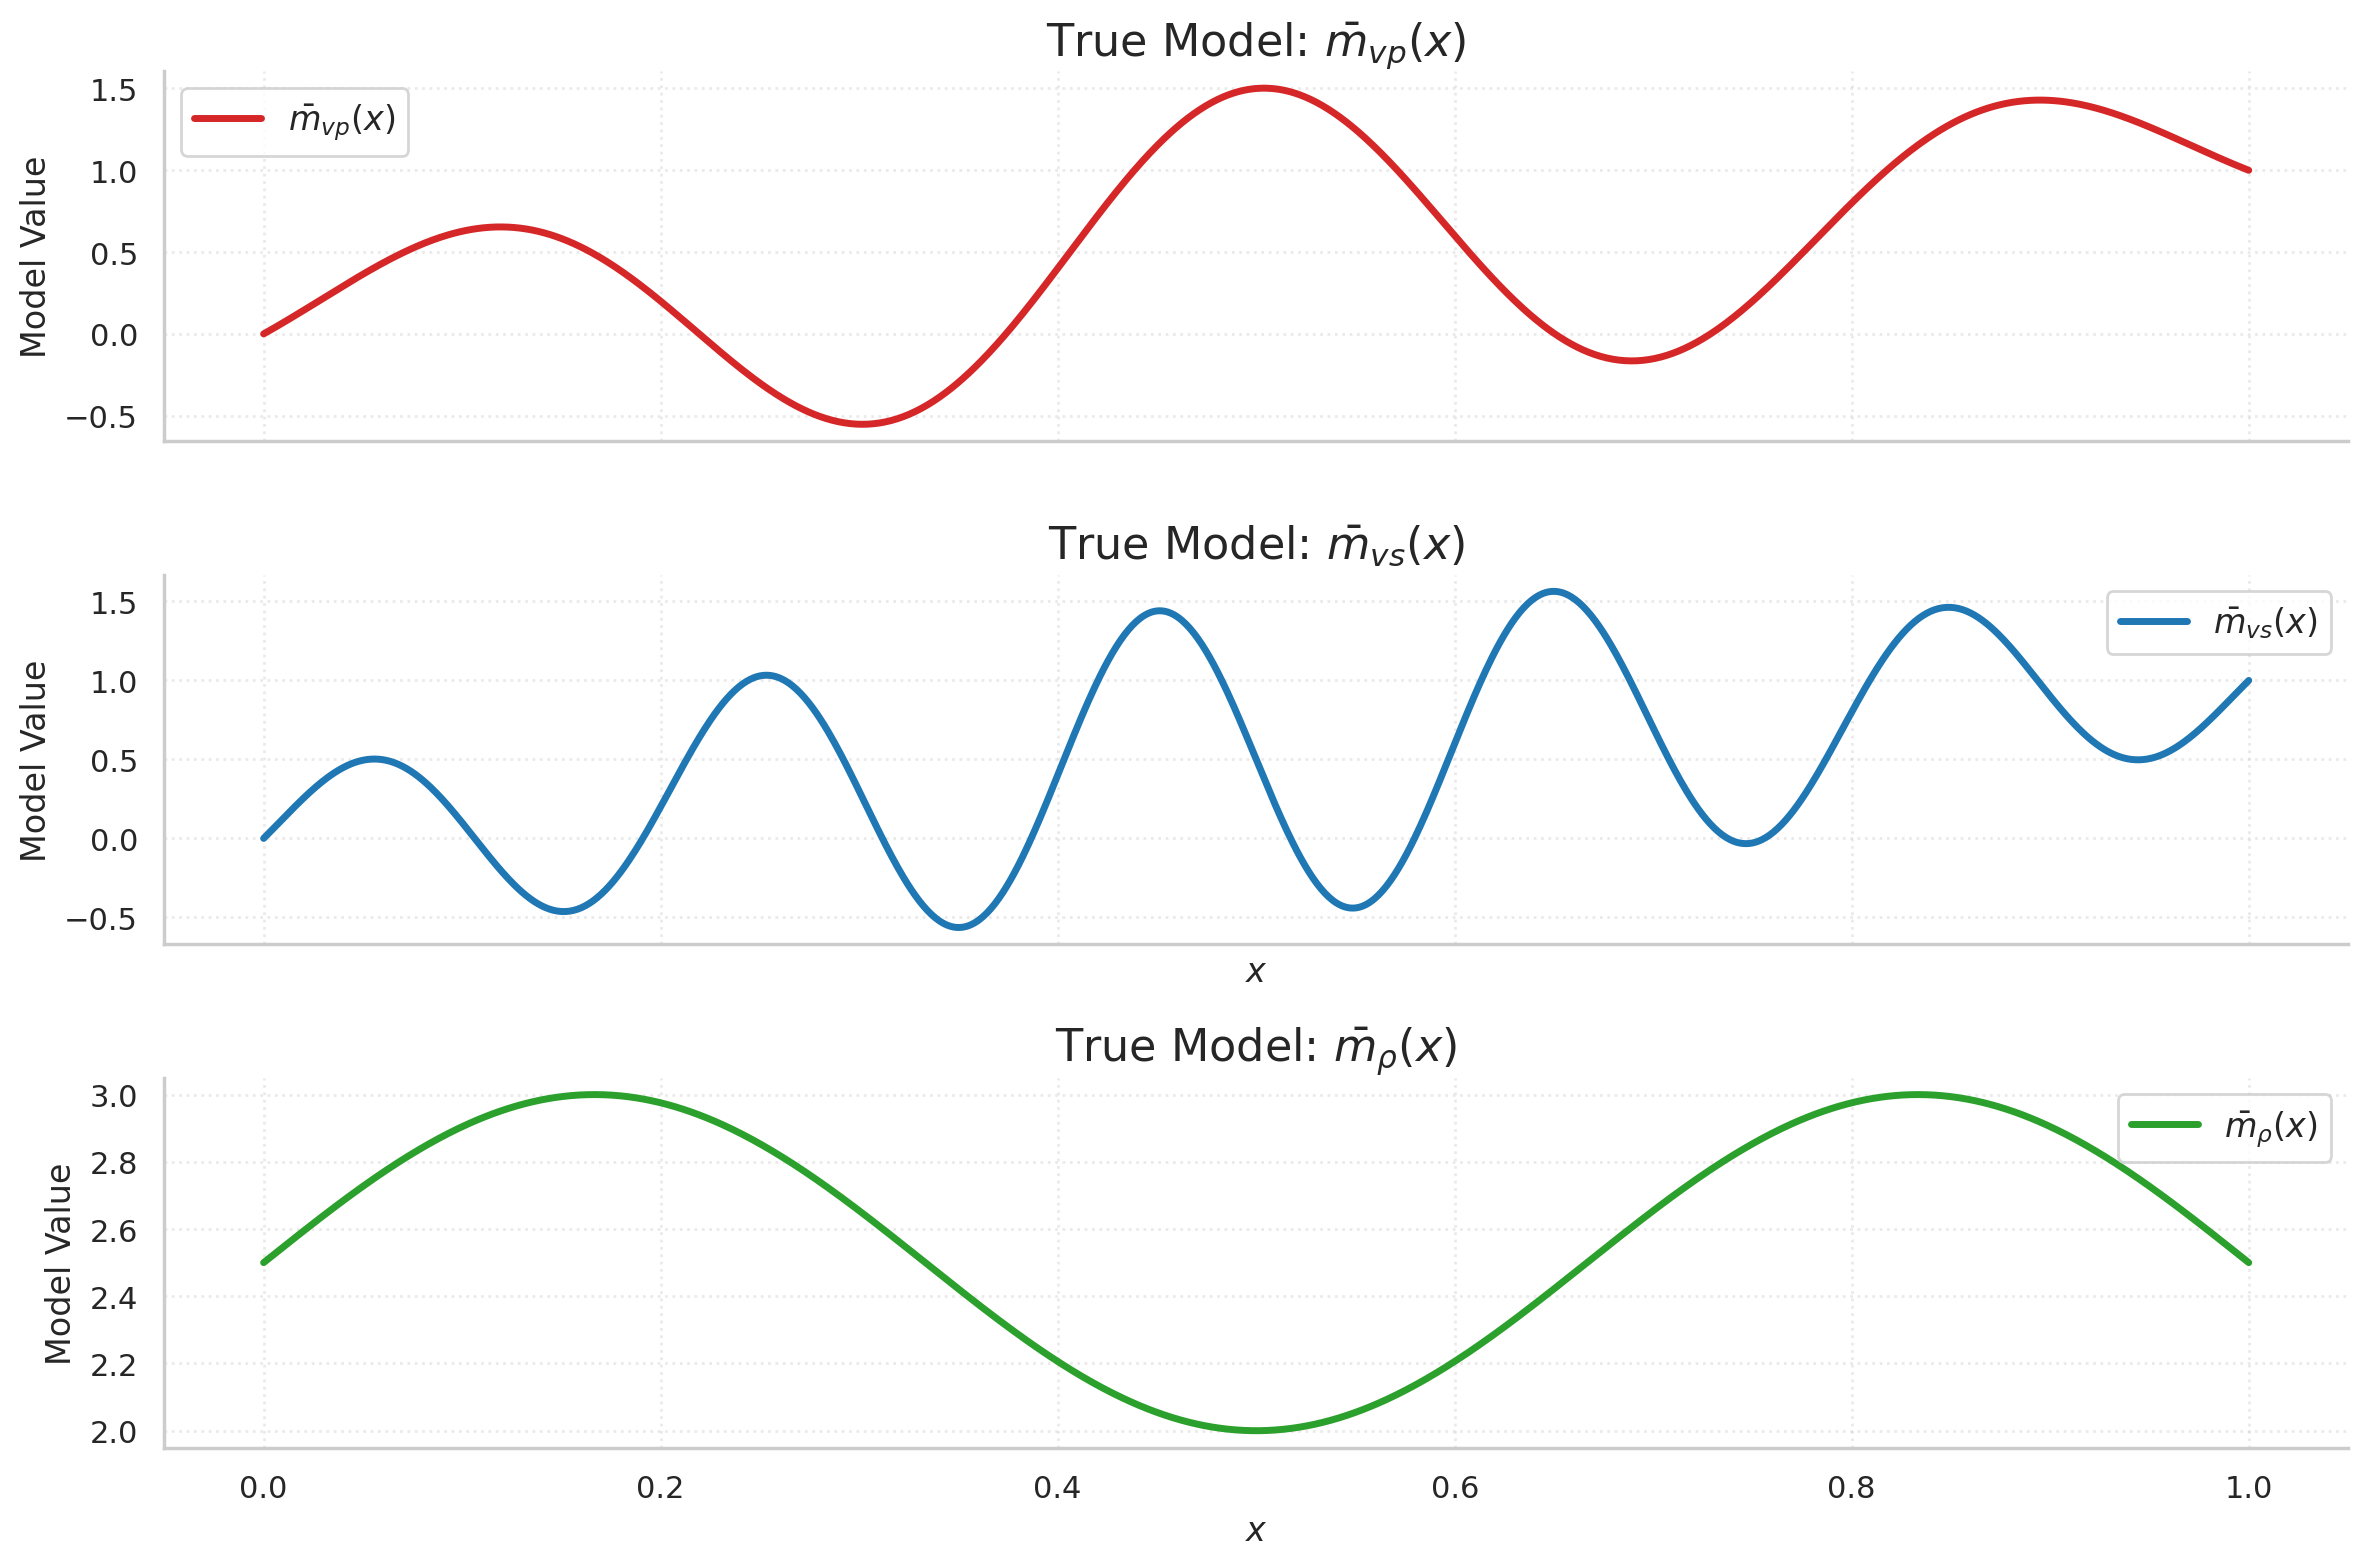

Generating synthetic data...
Signal-to-noise ratio: 10.0
Number of observations: 50


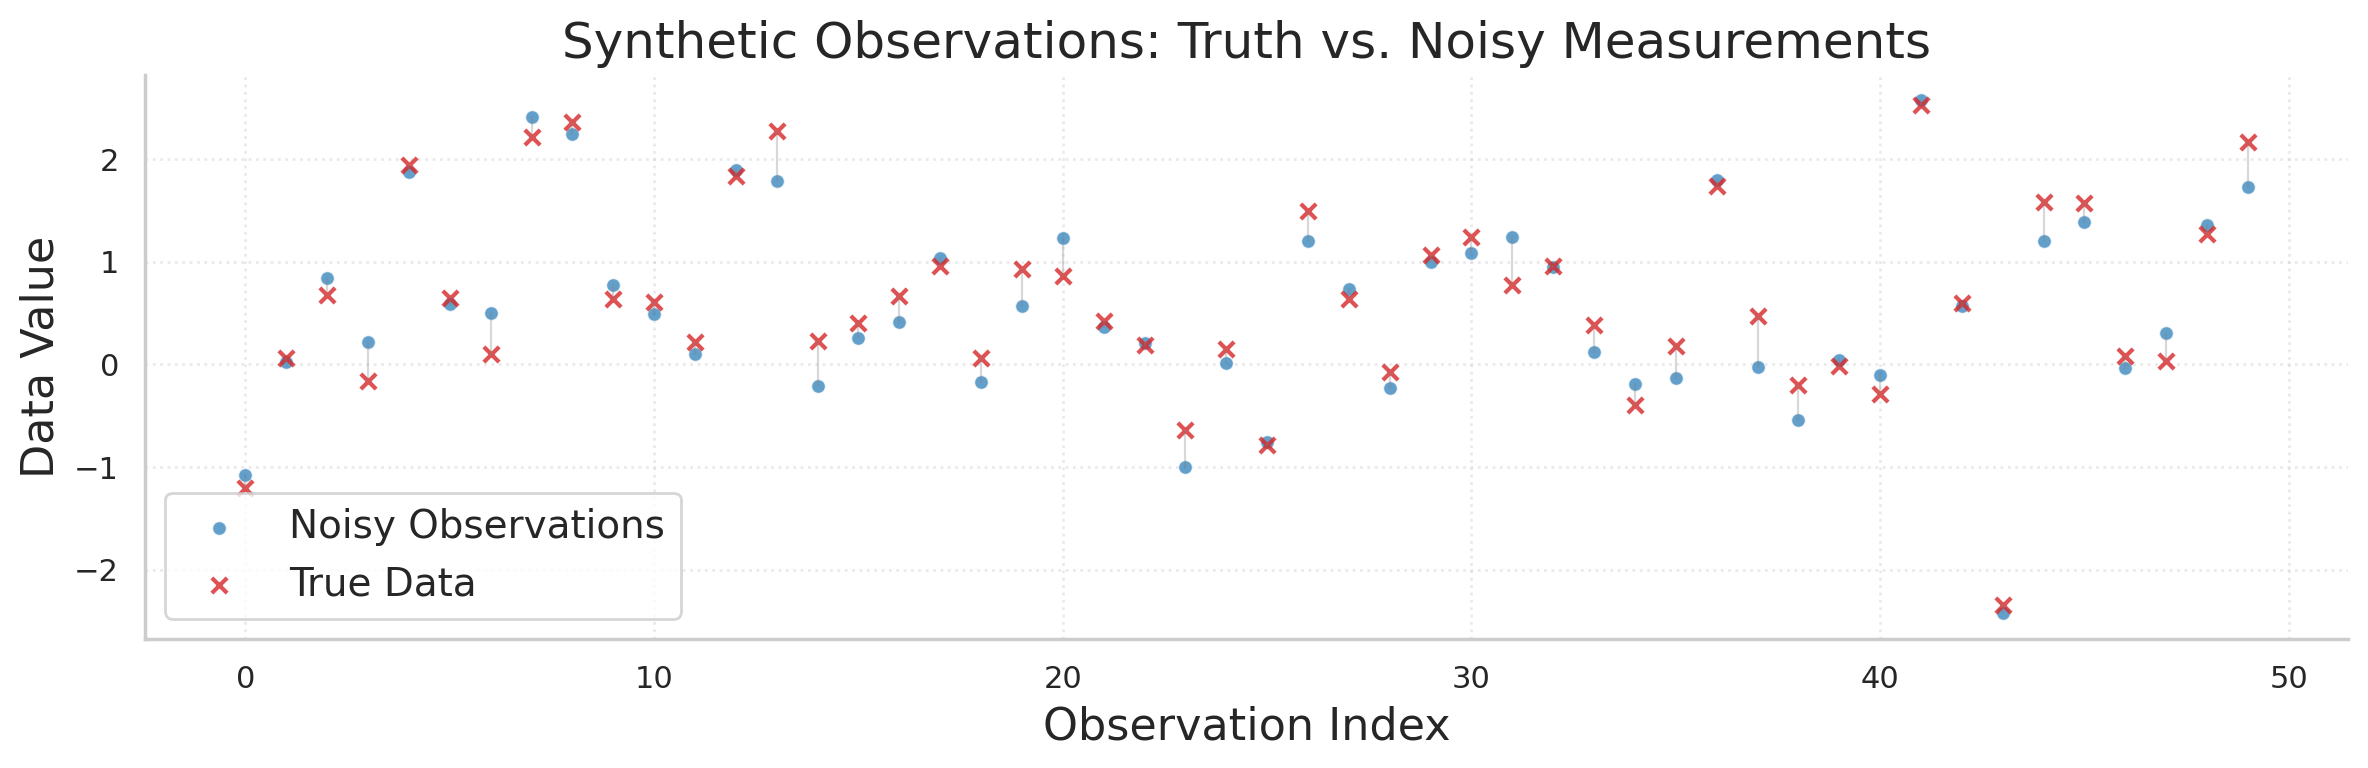

In [183]:
# Create the synthetic true models for vp and vs
m_bar_vp = Function(M_vp, evaluate_callable=lambda x: np.exp(-((x - function_domain.center)/0.5)**2) * np.sin(5 * np.pi * x) + x)
m_bar_vs = Function(M_vs, evaluate_callable=lambda x: np.exp(-((x - function_domain.center)/0.5)**2) * np.sin(10 * np.pi * x) + x)
m_bar_rho = Function(M_rho, evaluate_callable=lambda x: 2.5 + 0.5 * np.sin(3 * np.pi * x))
m_bar_sigma_0 = [0.1]
m_bar_sigma_1 = [0.2]
# Keep a combined representation if needed elsewhere
m_bar_functions = [m_bar_vp, m_bar_vs, m_bar_rho]
m_bar_euclidean = [m_bar_sigma_0, m_bar_sigma_1]
m_bar = [m_bar_functions, m_bar_euclidean]

# Evaluation grid (ensure x is defined locally)
x = np.linspace(function_domain.a, function_domain.b, 1000)

# True model plots: two stacked subplots (vp on top, vs on bottom)
fig_title = "True Models (vp & vs)"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

sns.set_theme(style="whitegrid", palette="muted", color_codes=True)
fig, axs = plt.subplots(3, 1, figsize=(12, 8), dpi=200, sharex=True)

# Top: vp
axs[0].plot(x, m_bar_vp.evaluate(x), color='tab:red', linewidth=2.5, label=r'$\bar{m}_{vp}(x)$')
axs[0].set_title(r"True Model: $\bar{m}_{vp}(x)$", fontsize=16)
axs[0].set_ylabel('Model Value', fontsize=12)
axs[0].legend(fontsize=12)
axs[0].grid(True, linestyle=':', alpha=0.4)

# Middle: vs
axs[1].plot(x, m_bar_vs.evaluate(x), color='tab:blue', linewidth=2.5, label=r'$\bar{m}_{vs}(x)$')
axs[1].set_title(r"True Model: $\bar{m}_{vs}(x)$", fontsize=16)
axs[1].set_xlabel(r"$x$", fontsize=12)
axs[1].set_ylabel('Model Value', fontsize=12)
axs[1].legend(fontsize=12)
axs[1].grid(True, linestyle=':', alpha=0.4)

# Bottom: rho
axs[2].plot(x, m_bar_rho.evaluate(x), color='tab:green', linewidth=2.5, label=r'$\bar{m}_{\rho}(x)$')
axs[2].set_title(r"True Model: $\bar{m}_{\rho}(x)$", fontsize=16)
axs[2].set_xlabel(r"$x$", fontsize=12)
axs[2].set_ylabel('Model Value', fontsize=12)
axs[2].legend(fontsize=12)
axs[2].grid(True, linestyle=':', alpha=0.4)

sns.despine()
plt.tight_layout()

# Save
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

# Generate synthetic observations
print("Generating synthetic data...")
d_bar = G(m_bar)  # Clean observations (may be a list/BlockVector)
# Ensure d_bar is a numpy array for noise addition and plotting

# Compute noise based on the numeric array
noise_level = 0.1 * np.max(d_bar)
np.random.seed(42)  # For reproducibility
d_tilde = [sub_d_bar + np.random.normal(0, noise_level, sub_d_bar.shape) for sub_d_bar in d_bar]

print(f"Signal-to-noise ratio: {np.max(d_bar) / noise_level:.1f}")
print(f"Number of observations: {len(d_tilde)}")

# Data comparison plot
fig_title = "Synthetic Observations"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 4), dpi=200)
data_indices = np.arange(len(d_bar))

# Plot connection lines between true and noisy data
for i in range(len(d_bar)):
    plt.plot([i, i], [d_bar[i], d_tilde[i]], color='gray', alpha=0.3, linewidth=0.8)

# Plot the data points
plt.scatter(data_indices, d_tilde, label='Noisy Observations',
           color='tab:blue', alpha=0.7, marker='o', s=25, edgecolors='white', linewidths=0.5)
plt.scatter(data_indices, d_bar, label='True Data',
           color='tab:red', alpha=0.8, marker='x', s=30, linewidths=1.5)

plt.xlabel('Observation Index', fontsize=16)
plt.ylabel('Data Value', fontsize=16)
plt.title('Synthetic Observations: Truth vs. Noisy Measurements', fontsize=18)
plt.legend(fontsize=14)
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

In [184]:
# Define data noise covariance
noise_variance = (0.1 * np.max(d_tilde))**2  # 10% of peak signal
C_D_matrix = noise_variance * np.eye(N_d)

print(f"Data noise standard deviation: {np.sqrt(noise_variance):.4f}")
print(f"Relative noise level: {100 * np.sqrt(noise_variance) / np.max(d_tilde):.1f}%")

# Create data NOISE measure (zero mean) for LinearForwardProblem
# This represents the noise model: η ~ N(0, C_D)
gaussian_D_noise = GaussianMeasure.from_covariance_matrix(D, C_D_matrix, expectation=np.zeros(N_d))

# Create data measure (with observed data mean) for visualization
# This represents the likelihood: d̃ | m ~ N(G(m), C_D)
gaussian_D = GaussianMeasure.from_covariance_matrix(D, C_D_matrix, expectation=d_tilde)

Data noise standard deviation: 0.2572
Relative noise level: 10.0%


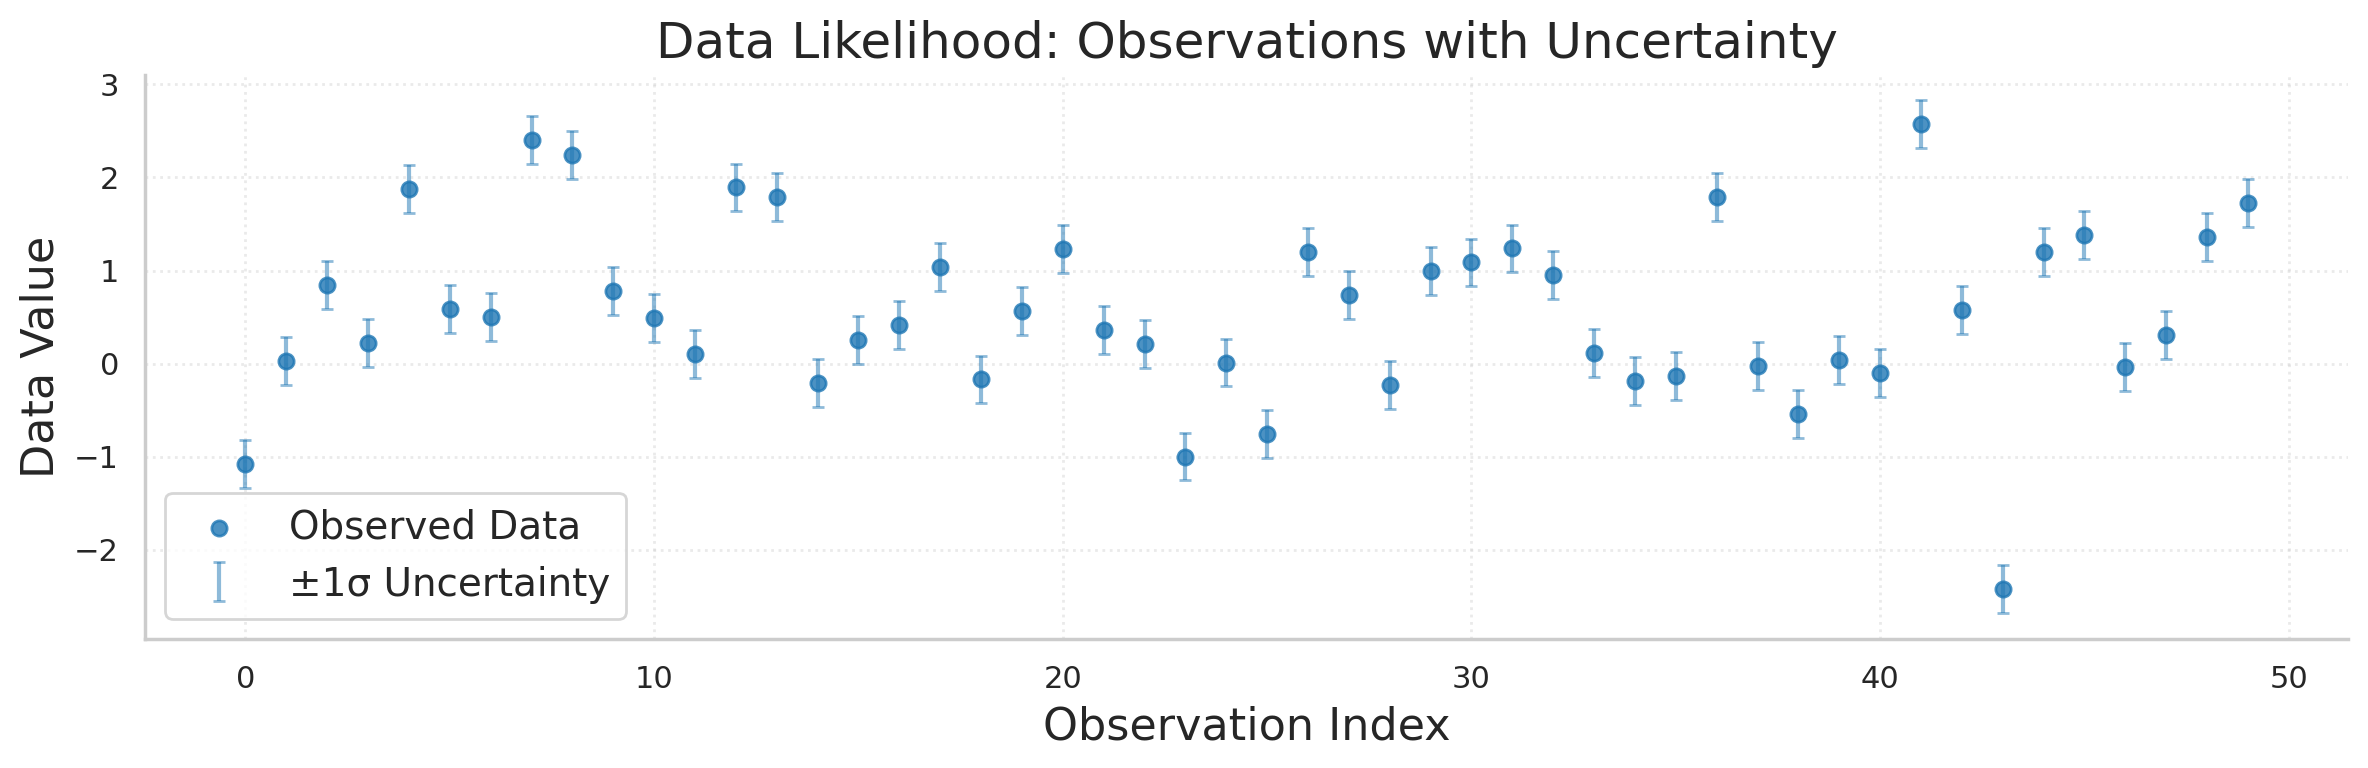

In [185]:
# Visualize the data measure (observed data with uncertainty)
# Note: We use gaussian_D (with data mean) for visualization, not gaussian_D_error (zero mean)
mean_values = gaussian_D.expectation
std_values = np.sqrt(noise_variance)

fig_title = "Data Likelihood Distribution"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 4), dpi=200)
data_indices = np.arange(len(mean_values))

plt.scatter(data_indices, mean_values, label='Observed Data', color='tab:blue', alpha=0.8, s=30)
plt.errorbar(data_indices, mean_values, yerr=std_values, fmt='none',
            color='tab:blue', alpha=0.5, capsize=2, capthick=1,
            label='±1σ Uncertainty')

plt.title("Data Likelihood: Observations with Uncertainty", fontsize=18)
plt.xlabel('Observation Index', fontsize=16)
plt.ylabel('Data Value', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

In [195]:
# Define prior measure parameters
bc_dirichlet = BoundaryConditions(bc_type='dirichlet')

# Prior covariance hyperparameters for vp
s_vp = 6.0              # Regularity/smoothness parameter
length_scale_vp = 0.3   # Correlation length scale (reduced to increase variance)
overall_variance_vp = np.power(10, 0.0)  # Overall variance scale (increased to boost variance)

# Derive Bessel-Sobolev parameters from hyperparameters
k_vp = np.power(overall_variance_vp, -0.5 / s_vp)
alpha_vp = (length_scale_vp ** 2) * (k_vp ** 2)

# Prior covariance hyperparameters for vs
s_vs = 6.0
length_scale_vs = 0.2
overall_variance_vs = np.power(10, 0.0)

# Derive Bessel-Sobolev parameters from hyperparameters
k_vs = np.power(overall_variance_vs, -0.5 / s_vs)
alpha_vs = (length_scale_vs ** 2) * (k_vs ** 2)

# Prior covariance hyperparameters for rho
s_rho = 5.0
length_scale_rho = 0.25
overall_variance_rho = np.power(10, 0.0)

# Derive Bessel-Sobolev parameters from hyperparameters
k_rho = np.power(overall_variance_rho, -0.5 / s_rho)
alpha_rho = (length_scale_rho ** 2) * (k_rho ** 2)

print(f"vp: s={s_vp}, length_scale={length_scale_vp}, overall_variance={overall_variance_vp}")
print(f"    Derived: k={k_vp:.4f}, alpha={alpha_vp:.4f}")
print(f"vs: s={s_vs}, length_scale={length_scale_vs}, overall_variance={overall_variance_vs}")
print(f"    Derived: k={k_vs:.4f}, alpha={alpha_vs:.4f}")
print(f"rho: s={s_rho}, length_scale={length_scale_rho}, overall_variance={overall_variance_rho}")
print(f"    Derived: k={k_rho:.4f}, alpha={alpha_rho:.4f}")

# Create Laplacian operators with integration config
L_vp = Laplacian(M_vp, bc_dirichlet, alpha_vp, method='spectral', dofs=100,
                 integration_config=laplacian_integration_cfg, n_samples=2048)
L_vs = Laplacian(M_vs, bc_dirichlet, alpha_vs, method='spectral', dofs=100,
                 integration_config=laplacian_integration_cfg, n_samples=2048)
L_rho = Laplacian(M_rho, bc_dirichlet, alpha_rho, method='spectral', dofs=100,
                  integration_config=laplacian_integration_cfg, n_samples=2048)

# Create Bessel-Sobolev inverse operators as prior covariance
C_0_vp = BesselSobolevInverse(
    M_vp, M_vp, k_vp, s_vp, L_vp,
    dofs=100, n_samples=2048, use_fast_transforms=True
)
C_0_vs = BesselSobolevInverse(
    M_vs, M_vs, k_vs, s_vs, L_vs,
    dofs=100, n_samples=2048, use_fast_transforms=True
)
C_0_rho = BesselSobolevInverse(
    M_rho, M_rho, k_rho, s_rho, L_rho,
    dofs=100, n_samples=2048, use_fast_transforms=True
)

# Prior means
m_0_vp = Function(M_vp, evaluate_callable=lambda x: np.zeros_like(x))
m_0_vs = Function(M_vs, evaluate_callable=lambda x: np.zeros_like(x))
m_0_rho = Function(M_rho, evaluate_callable=lambda x: np.zeros_like(x))


K = 100  # Number of KL terms
print(f"Using {K} Karhunen-Loève terms for prior sampling")

# Create Gaussian measures on each component space using KL sampler
sampler_vp = KLSampler(C_0_vp, mean=m_0_vp, n_modes=K)
M_prior_vp = GaussianMeasure(covariance=C_0_vp, expectation=m_0_vp, sample=sampler_vp.sample)

sampler_vs = KLSampler(C_0_vs, mean=m_0_vs, n_modes=K)
M_prior_vs = GaussianMeasure(covariance=C_0_vs, expectation=m_0_vs, sample=sampler_vs.sample)

sampler_rho = KLSampler(C_0_rho, mean=m_0_rho, n_modes=K)
M_prior_rho = GaussianMeasure(covariance=C_0_rho, expectation=m_0_rho, sample=sampler_rho.sample)

m_0_sigma_0 = np.array([0.0])
m_0_sigma_1 = np.array([0.0])
M_prior_sigma_0 = GaussianMeasure.from_covariance_matrix(M_sigma_0, np.array([[0.01]]), expectation=m_0_sigma_0)
M_prior_sigma_1 = GaussianMeasure.from_covariance_matrix(M_sigma_1, np.array([[0.01]]), expectation=m_0_sigma_1)

# Combine into a joint prior measure
M_prior_functions = GaussianMeasure.from_direct_sum([M_prior_vp, M_prior_vs, M_prior_rho])
M_prior_euclidean = GaussianMeasure.from_direct_sum([M_prior_sigma_0, M_prior_sigma_1])
M_prior = GaussianMeasure.from_direct_sum([M_prior_functions, M_prior_euclidean])

vp: s=6.0, length_scale=0.3, overall_variance=1.0
    Derived: k=1.0000, alpha=0.0900
vs: s=6.0, length_scale=0.2, overall_variance=1.0
    Derived: k=1.0000, alpha=0.0400
rho: s=5.0, length_scale=0.25, overall_variance=1.0
    Derived: k=1.0000, alpha=0.0625
Using 100 Karhunen-Loève terms for prior sampling


Computing prior uncertainty (vp) via KL variance...
Computing prior uncertainty (vs) via KL variance...
Computing prior uncertainty (rho) via KL variance...
Drawing samples from prior measure...
Plotting sigma_0 prior distribution...
Plotting sigma_1 prior distribution...
Plotting sigma_0 prior distribution...
Plotting sigma_1 prior distribution...


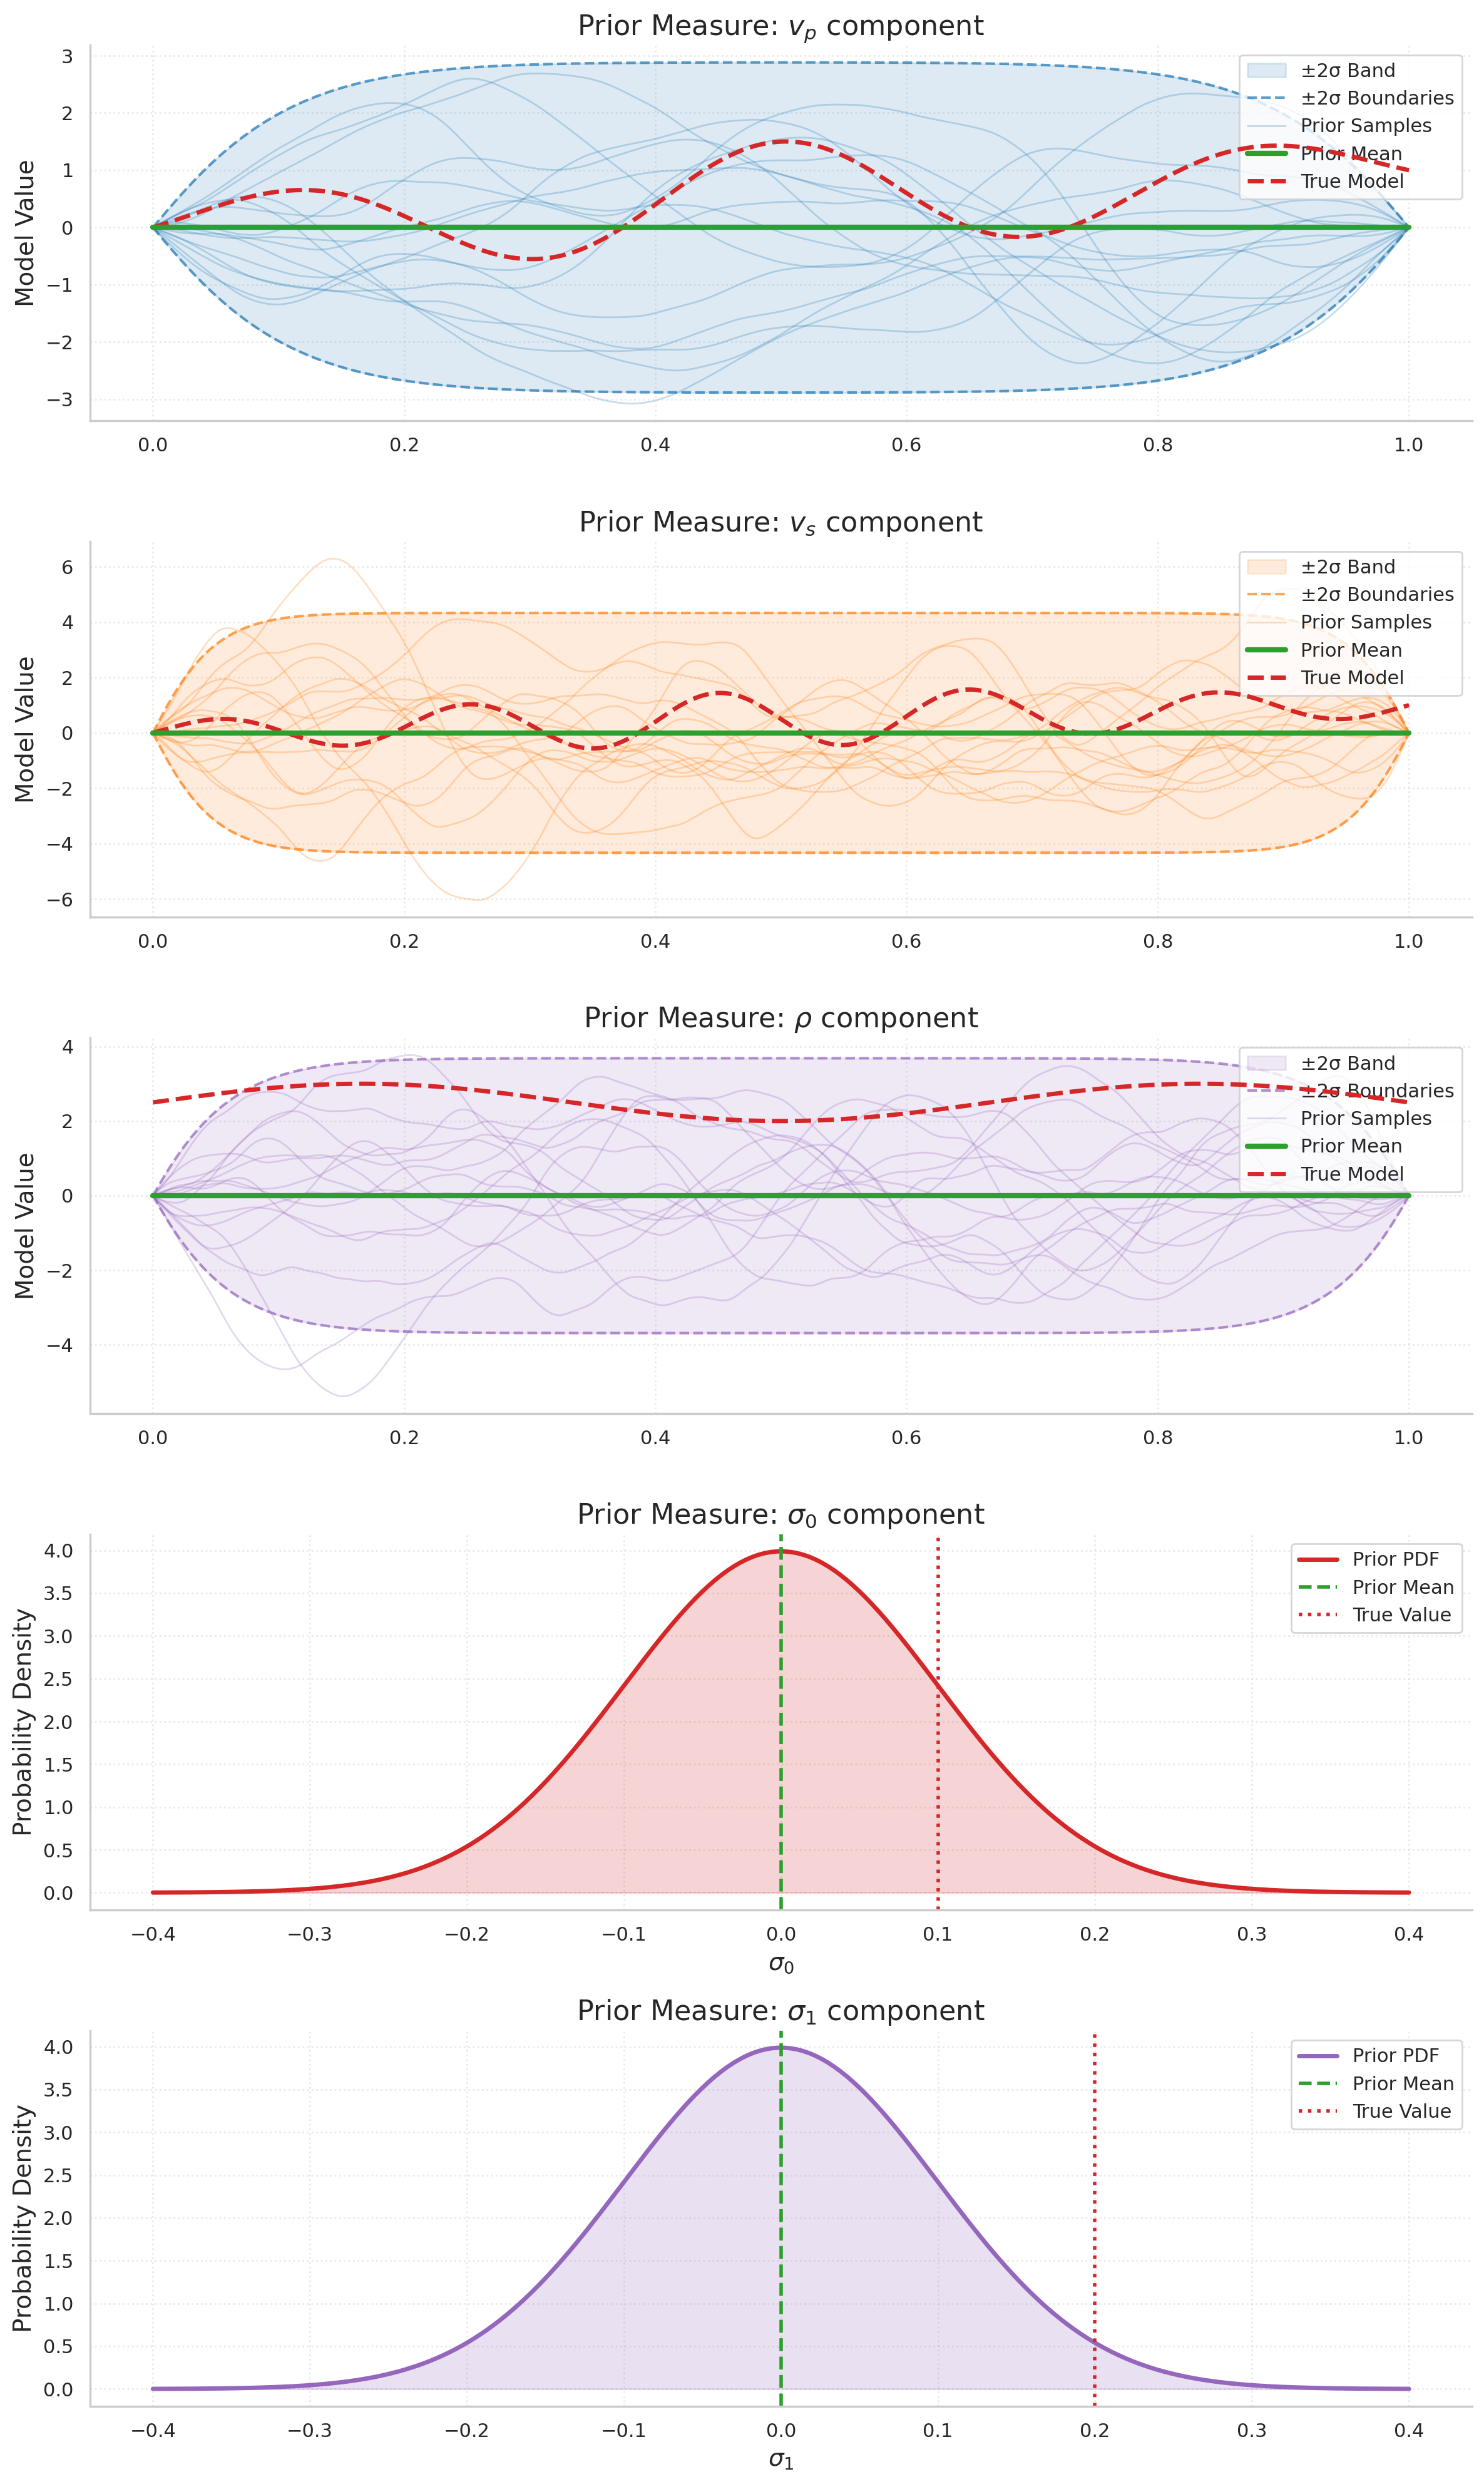

In [196]:
# Visualize the prior measure (two subplots for vp and vs)
fig_title = "Prior Measure on Model Space (vp & vs & rho)"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

# Parameters for visualization
num_samples = 15
sample_color_vp = 'tab:blue'
sample_color_vs = 'tab:orange'
sample_color_rho = 'tab:purple'
mean_color = 'tab:green'
std_color_vp = 'tab:blue'
std_color_vs = 'tab:orange'
std_color_rho = 'tab:purple'

# Create 5 vertically stacked subplots (3 for functions, 2 for sigmas)
fig, axs = plt.subplots(5, 1, figsize=(12, 20), dpi=200)

# Compute and plot uncertainty bounds for vp FIRST
print("Computing prior uncertainty (vp) via KL variance...")
variance_func_vp = sampler_vp.variance_function()
std_values_vp = np.sqrt(variance_func_vp.evaluate(x))

# Compute and plot uncertainty bounds for vs FIRST
print("Computing prior uncertainty (vs) via KL variance...")
variance_func_vs = sampler_vs.variance_function()
std_values_vs = np.sqrt(variance_func_vs.evaluate(x))

# Compute and plot uncertainty bounds for rho FIRST
print("Computing prior uncertainty (rho) via KL variance...")
variance_func_rho = sampler_rho.variance_function()
std_values_rho = np.sqrt(variance_func_rho.evaluate(x))

# Plot prior mean and uncertainty for vp (top subplot) - PLOT THESE FIRST
(mean_vp, mean_vs, mean_rho), (mean_sigma_0, mean_sigma_1) = M_prior.expectation  # Unpack direct-sum expectation
mean_values_vp = mean_vp.evaluate(x)
axs[0].fill_between(x, mean_values_vp - 2*std_values_vp, mean_values_vp + 2*std_values_vp,
                     color=std_color_vp, alpha=0.15, label='±2σ Band', zorder=1)
axs[0].plot(x, mean_values_vp + 2*std_values_vp, color=std_color_vp, linestyle='--',
            alpha=0.7, linewidth=1.5, label='±2σ Boundaries', zorder=2)
axs[0].plot(x, mean_values_vp - 2*std_values_vp, color=std_color_vp, linestyle='--',
            alpha=0.7, linewidth=1.5, zorder=2)

# Plot prior mean and uncertainty for vs (second subplot) - PLOT THESE FIRST
mean_values_vs = mean_vs.evaluate(x)
axs[1].fill_between(x, mean_values_vs - 2*std_values_vs, mean_values_vs + 2*std_values_vs,
                     color=std_color_vs, alpha=0.15, label='±2σ Band', zorder=1)
axs[1].plot(x, mean_values_vs + 2*std_values_vs, color=std_color_vs, linestyle='--',
            alpha=0.7, linewidth=1.5, label='±2σ Boundaries', zorder=2)
axs[1].plot(x, mean_values_vs - 2*std_values_vs, color=std_color_vs, linestyle='--',
            alpha=0.7, linewidth=1.5, zorder=2)

# Plot prior mean and uncertainty for rho (third subplot) - PLOT THESE FIRST
mean_values_rho = mean_rho.evaluate(x)
axs[2].fill_between(x, mean_values_rho - 2*std_values_rho, mean_values_rho + 2*std_values_rho,
                     color=std_color_rho, alpha=0.15, label='±2σ Band', zorder=1)
axs[2].plot(x, mean_values_rho + 2*std_values_rho, color=std_color_rho, linestyle='--',
            alpha=0.7, linewidth=1.5, label='±2σ Boundaries', zorder=2)
axs[2].plot(x, mean_values_rho - 2*std_values_rho, color=std_color_rho, linestyle='--',
            alpha=0.7, linewidth=1.5, zorder=2)

# Plot prior samples for vp, vs, and rho - WITH ZORDER
print("Drawing samples from prior measure...")
for i in range(num_samples):
    sample = M_prior.sample()  # Returns [[sample_vp, sample_vs, sample_rho], [sample_sigma_0, sample_sigma_1]]
    (sample_vp, sample_vs, sample_rho), (sample_sigma_0, sample_sigma_1) = sample

    # First subplot: vp
    axs[0].plot(x, sample_vp.evaluate(x), color=sample_color_vp, alpha=0.25, linewidth=1,
                label='Prior Samples' if i == 0 else "", zorder=3)

    # Second subplot: vs
    axs[1].plot(x, sample_vs.evaluate(x), color=sample_color_vs, alpha=0.25, linewidth=1,
                label='Prior Samples' if i == 0 else "", zorder=3)

    # Third subplot: rho
    axs[2].plot(x, sample_rho.evaluate(x), color=sample_color_rho, alpha=0.25, linewidth=1,
                label='Prior Samples' if i == 0 else "", zorder=3)

# Plot prior mean and true model on TOP
axs[0].plot(x, mean_values_vp, color=mean_color, linewidth=3, label='Prior Mean', zorder=10)
axs[0].plot(x, m_bar_vp.evaluate(x), color='tab:red', linewidth=2.5,
            label='True Model', linestyle='--', zorder=9)

axs[1].plot(x, mean_values_vs, color=mean_color, linewidth=3, label='Prior Mean', zorder=10)
axs[1].plot(x, m_bar_vs.evaluate(x), color='tab:red', linewidth=2.5,
            label='True Model', linestyle='--', zorder=9)

axs[2].plot(x, mean_values_rho, color=mean_color, linewidth=3, label='Prior Mean', zorder=10)
axs[2].plot(x, m_bar_rho.evaluate(x), color='tab:red', linewidth=2.5,
            label='True Model', linestyle='--', zorder=9)

# Set titles and labels for function space components
axs[0].set_title(r"Prior Measure: $v_p$ component", fontsize=16)
axs[0].set_ylabel("Model Value", fontsize=14)
axs[0].legend(fontsize=11, loc='upper right')
axs[0].grid(True, linestyle=':', alpha=0.4)

axs[1].set_title(r"Prior Measure: $v_s$ component", fontsize=16)
axs[1].set_ylabel("Model Value", fontsize=14)
axs[1].legend(fontsize=11, loc='upper right')
axs[1].grid(True, linestyle=':', alpha=0.4)

axs[2].set_title(r"Prior Measure: $\rho$ component", fontsize=16)
axs[2].set_ylabel("Model Value", fontsize=14)
axs[2].legend(fontsize=11, loc='upper right')
axs[2].grid(True, linestyle=':', alpha=0.4)

# Fourth subplot: sigma_0 Gaussian distribution
print("Plotting sigma_0 prior distribution...")
sigma_0_mean = mean_sigma_0[0]
sigma_0_std = np.sqrt(M_prior_sigma_0.covariance.matrix(dense=True)[0, 0])
sigma_0_range = np.linspace(sigma_0_mean - 4*sigma_0_std, sigma_0_mean + 4*sigma_0_std, 200)
sigma_0_pdf = (1 / (sigma_0_std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((sigma_0_range - sigma_0_mean) / sigma_0_std)**2)

axs[3].plot(sigma_0_range, sigma_0_pdf, color='tab:red', linewidth=2.5, label='Prior PDF')
axs[3].axvline(sigma_0_mean, color='tab:green', linewidth=2, linestyle='--', label='Prior Mean')
axs[3].axvline(m_bar_sigma_0[0], color='tab:red', linewidth=2, linestyle=':', label='True Value')
axs[3].fill_between(sigma_0_range, 0, sigma_0_pdf, color='tab:red', alpha=0.2)
axs[3].set_title(r"Prior Measure: $\sigma_0$ component", fontsize=16)
axs[3].set_xlabel(r"$\sigma_0$", fontsize=14)
axs[3].set_ylabel("Probability Density", fontsize=14)
axs[3].legend(fontsize=11, loc='upper right')
axs[3].grid(True, linestyle=':', alpha=0.4)

# Fifth subplot: sigma_1 Gaussian distribution
print("Plotting sigma_1 prior distribution...")
sigma_1_mean = mean_sigma_1[0]
sigma_1_std = np.sqrt(M_prior_sigma_1.covariance.matrix(dense=True)[0, 0])
sigma_1_range = np.linspace(sigma_1_mean - 4*sigma_1_std, sigma_1_mean + 4*sigma_1_std, 200)
sigma_1_pdf = (1 / (sigma_1_std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((sigma_1_range - sigma_1_mean) / sigma_1_std)**2)

axs[4].plot(sigma_1_range, sigma_1_pdf, color='tab:purple', linewidth=2.5, label='Prior PDF')
axs[4].axvline(sigma_1_mean, color='tab:green', linewidth=2, linestyle='--', label='Prior Mean')
axs[4].axvline(m_bar_sigma_1[0], color='tab:red', linewidth=2, linestyle=':', label='True Value')
axs[4].fill_between(sigma_1_range, 0, sigma_1_pdf, color='tab:purple', alpha=0.2)
axs[4].set_title(r"Prior Measure: $\sigma_1$ component", fontsize=16)
axs[4].set_xlabel(r"$\sigma_1$", fontsize=14)
axs[4].set_ylabel("Probability Density", fontsize=14)
axs[4].legend(fontsize=11, loc='upper right')
axs[4].grid(True, linestyle=':', alpha=0.4)

sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()


In [197]:
# Compute property prior by pushing model prior through target operator
print("Computing property prior measure...")
prior_P = M_prior.affine_mapping(operator=T)
std_P = np.sqrt(np.diag(prior_P.covariance.matrix(dense=True, parallel=True, n_jobs=8)))

print(f"Property prior computed for {N_p} target locations")
print(f"Property uncertainty range: [{std_P.min():.3f}, {std_P.max():.3f}]")

Computing property prior measure...


Property prior computed for 20 target locations
Property uncertainty range: [0.920, 1.401]


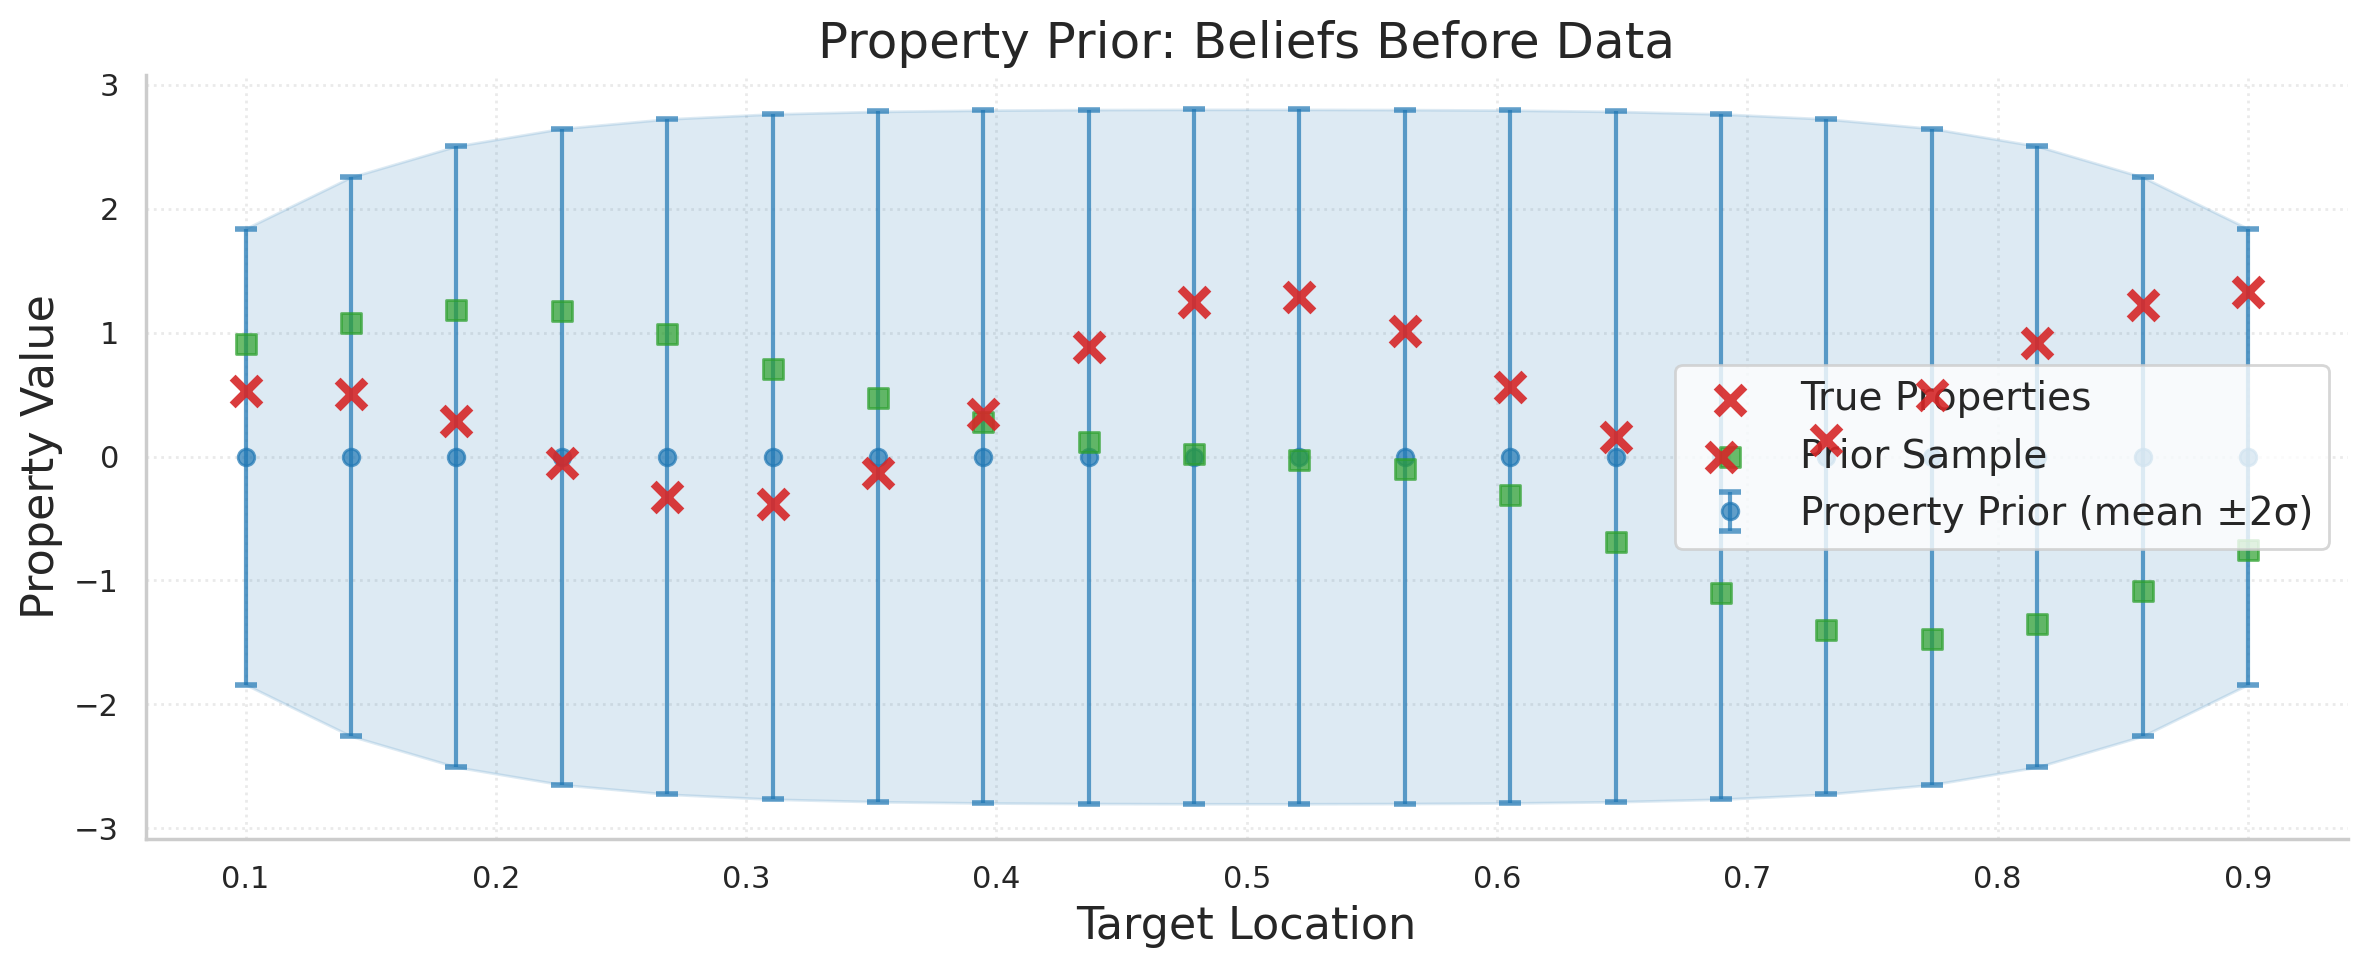

True properties range: [-0.381, 1.332]
How many true properties are within prior ±2σ: 20/20


In [198]:
# Visualize property prior
fig_title = "Property Prior Distribution"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 5), dpi=200)

# Property prior mean and uncertainty
mean_prop = T(M_prior.expectation)
plt.errorbar(centers, mean_prop, yerr=2*std_P, fmt='o', color='tab:blue',
            alpha=0.7, capsize=4, capthick=2, markersize=6,
            label='Property Prior (mean ±2σ)')
plt.fill_between(centers, mean_prop - 2*std_P, mean_prop + 2*std_P,
                color='tab:blue', alpha=0.15)

# True property values
true_props = T(m_bar)
plt.scatter(centers, true_props, label='True Properties',
           color='tab:red', marker='x', s=100, alpha=0.9, linewidths=3, zorder=10)

# Sample from property prior
sampled_props = prior_P.sample()
plt.scatter(centers, sampled_props, label='Prior Sample',
           color='tab:green', marker='s', s=50, alpha=0.7, zorder=5)

plt.xlabel('Target Location', fontsize=16)
plt.ylabel('Property Value', fontsize=16)
plt.title('Property Prior: Beliefs Before Data', fontsize=18)
plt.legend(fontsize=14)
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

# Print some statistics
print(f"True properties range: [{true_props.min():.3f}, {true_props.max():.3f}]")
print(f"How many true properties are within prior ±2σ: {np.sum(np.abs(true_props - mean_prop) <= 2*std_P)}/{len(true_props)}")

In [199]:
# Bayesian inference setup and posterior computation
import time

print("="*80)
print("BAYESIAN INFERENCE")
print("="*80)

# Common setup
t0 = time.time()
print("\nSetting up Bayesian inference...")
forward_problem = LinearForwardProblem(G, data_error_measure=gaussian_D_noise)
bayesian_inference = LinearBayesianInference(forward_problem, M_prior, T)
solver = CholeskySolver(parallel=True, n_jobs=30)
t1 = time.time()
print(f"   Setup time: {t1-t0:.3f}s")

if COMPUTE_MODEL_POSTERIOR:
    print("\n" + "="*80)
    print("WORKFLOW 1: Model Posterior → Property Posterior")
    print("="*80)

    # Compute model posterior
    print("\n1. Computing model posterior measure...")
    t2 = time.time()
    posterior_model = bayesian_inference.model_posterior_measure(d_tilde, solver)
    t3 = time.time()
    print(f"   Time: {t3-t2:.3f}s")

    # Extract dense matrix
    print("\n2. Extracting dense covariance matrix...")
    t4 = time.time()
    C_M_matrix = posterior_model.covariance.matrix(dense=True, parallel=True, n_jobs=30)
    t5 = time.time()
    print(f"   Time: {t5-t4:.3f}s")

    # Create sampling-capable measure
    print("\n3. Creating sampling-capable measure...")
    t6 = time.time()
    mu_M = GaussianMeasure.from_covariance_matrix(M_model, C_M_matrix, expectation=posterior_model.expectation)
    m_tilde = mu_M.expectation
    t7 = time.time()
    print(f"   Time: {t7-t6:.3f}s")

    # Compute property posterior by pushing model posterior
    print("\n4. Computing property posterior (via model)...")
    t8 = time.time()
    property_posterior = mu_M.affine_mapping(operator=T)
    p_tilde = property_posterior.expectation
    cov_P_matrix = property_posterior.covariance.matrix(dense=True, parallel=True, n_jobs=30)
    t9 = time.time()
    print(f"   Time: {t9-t8:.3f}s")

    total_time = t9 - t0
    print(f"\n{'='*80}")
    print(f"WORKFLOW 1 TOTAL TIME: {total_time:.3f}s")
    print(f"{'='*80}")
    print("\nBreakdown:")
    print(f"  Setup:             {(t1-t0)/total_time*100:5.1f}%  ({t1-t0:.3f}s)")
    print(f"  Model posterior:   {(t3-t2)/total_time*100:5.1f}%  ({t3-t2:.3f}s)")
    print(f"  Dense matrix:      {(t5-t4)/total_time*100:5.1f}%  ({t5-t4:.3f}s)")
    print(f"  Measure creation:  {(t7-t6)/total_time*100:5.1f}%  ({t7-t6:.3f}s)")
    print(f"  Property posterior:{(t9-t8)/total_time*100:5.1f}%  ({t9-t8:.3f}s)")

else:
    print("\n" + "="*80)
    print("WORKFLOW 2: Property Posterior Directly (Skip Model)")
    print("="*80)

    # Compute model posterior mean only (no dense covariance)
    print("\n1. Computing model posterior (mean only)...")
    t2 = time.time()
    posterior_model = bayesian_inference.model_posterior_measure(d_tilde, solver)
    m_tilde = posterior_model.expectation
    t3 = time.time()
    print(f"   Time: {t3-t2:.3f}s")

    # Push to property space (fast - no dense matrices involved)
    print("\n2. Computing property posterior...")
    t4 = time.time()
    property_posterior = posterior_model.affine_mapping(operator=T)
    p_tilde = property_posterior.expectation
    t5 = time.time()
    print(f"   Time: {t5-t4:.3f}s")

    # Extract only the small property covariance matrix
    print("\n3. Extracting property covariance...")
    t6 = time.time()
    cov_P_matrix = property_posterior.covariance.matrix(dense=True, parallel=True, n_jobs=30)
    t7 = time.time()
    print(f"   Time: {t7-t6:.3f}s")

    total_time = t7 - t0
    print(f"\n{'='*80}")
    print(f"WORKFLOW 2 TOTAL TIME: {total_time:.3f}s")
    print(f"{'='*80}")
    print("\nBreakdown:")
    print(f"  Setup:             {(t1-t0)/total_time*100:5.1f}%  ({t1-t0:.3f}s)")
    print(f"  Model posterior:   {(t3-t2)/total_time*100:5.1f}%  ({t3-t2:.3f}s)")
    print(f"  Push to property:  {(t5-t4)/total_time*100:5.1f}%  ({t5-t4:.3f}s)")
    print(f"  Property cov:      {(t7-t6)/total_time*100:5.1f}%  ({t7-t6:.3f}s)")
    print("\n💡 Skipped expensive dense model covariance extraction!")

print(f"{'='*80}")

# Data fit (works for both workflows)
data_misfit = np.linalg.norm(G(m_tilde) - d_tilde)
print(f"\nData misfit (posterior): {data_misfit:.4f}")
print(f"Data misfit (prior):     {np.linalg.norm(G([[m_0_vp, m_0_vs, m_0_rho],[m_0_sigma_0, m_0_sigma_1]]) - d_tilde):.4f}")

# Show improvement
relative_improvement = 1 - data_misfit / np.linalg.norm(G([[m_0_vp, m_0_vs, m_0_rho],[m_0_sigma_0, m_0_sigma_1]]) - d_tilde)
print(f"Data fit improvement: {100 * relative_improvement:.1f}%")

BAYESIAN INFERENCE

Setting up Bayesian inference...
   Setup time: 0.000s

WORKFLOW 1: Model Posterior → Property Posterior

1. Computing model posterior measure...
   Time: 12.073s

2. Extracting dense covariance matrix...
   Time: 12.073s

2. Extracting dense covariance matrix...
   Time: 68.094s

3. Creating sampling-capable measure...
   Time: 0.055s

4. Computing property posterior (via model)...
   Time: 68.094s

3. Creating sampling-capable measure...
   Time: 0.055s

4. Computing property posterior (via model)...
   Time: 2.594s

WORKFLOW 1 TOTAL TIME: 82.817s

Breakdown:
  Setup:               0.0%  (0.000s)
  Model posterior:    14.6%  (12.073s)
  Dense matrix:       82.2%  (68.094s)
  Measure creation:    0.1%  (0.055s)
  Property posterior:  3.1%  (2.594s)
   Time: 2.594s

WORKFLOW 1 TOTAL TIME: 82.817s

Breakdown:
  Setup:               0.0%  (0.000s)
  Model posterior:    14.6%  (12.073s)
  Dense matrix:       82.2%  (68.094s)
  Measure creation:    0.1%  (0.055s)
  Prop

Sampling from model posterior...
Plotting sigma_0 posterior distribution...
Plotting sigma_0 posterior distribution...
Plotting sigma_1 posterior distribution...
Plotting sigma_1 posterior distribution...


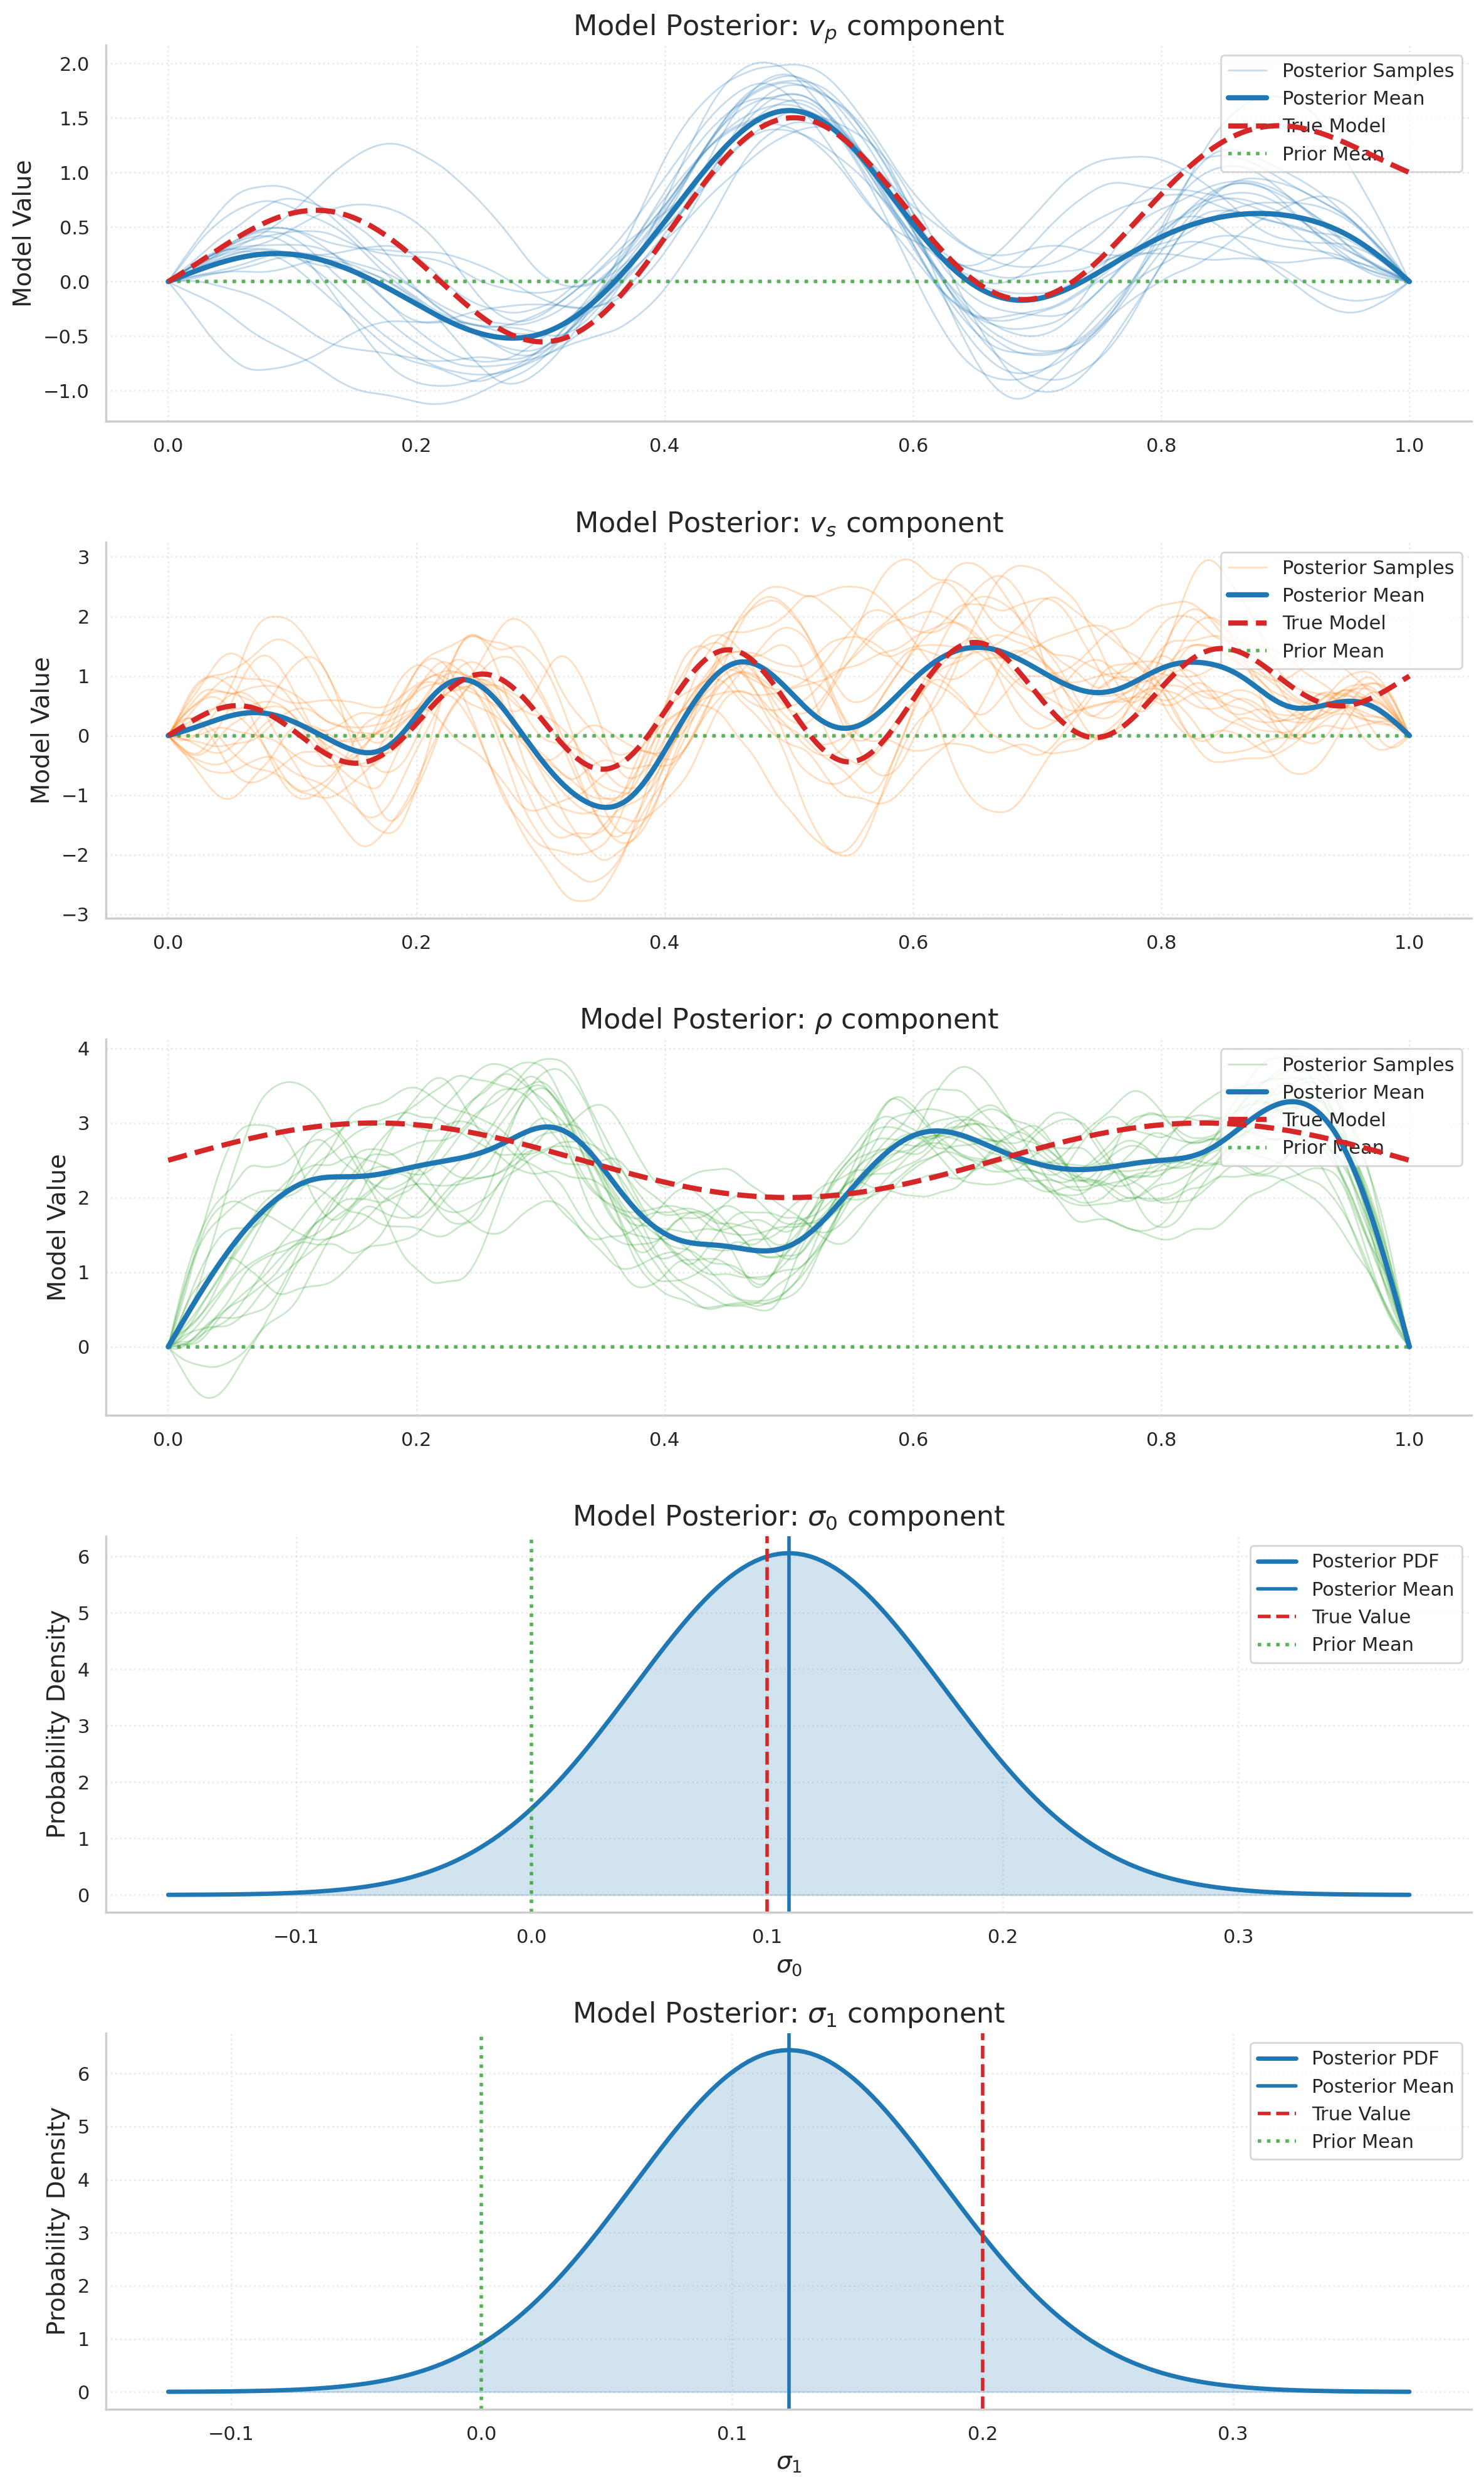

RMS reconstruction error (vp): 0.3976
RMS reconstruction error (vs): 0.4100
RMS reconstruction error (rho): 0.7370
Absolute reconstruction error (sigma_0): 0.0092
Absolute reconstruction error (sigma_1): 0.0773
Relative error (vp): 64.4%
Relative error (vs): 68.4%
Relative error (rho): 218.6%
Relative error (sigma_0): 9.2%
Relative error (sigma_1): 38.7%


In [200]:
if COMPUTE_MODEL_POSTERIOR:
    # Visualize posterior measure on model space with samples (vp & vs & rho & sigmas)
    fig_title = "Model Posterior Distribution (vp & vs & rho & sigmas)"
    filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

    # Plot posterior samples
    num_samples = 20
    sample_color_vp = 'tab:blue'
    sample_color_vs = 'tab:orange'
    sample_color_rho = 'tab:green'

    # Create five vertically stacked subplots (3 functions + 2 sigmas)
    fig, axs = plt.subplots(5, 1, figsize=(12, 20), dpi=200)

    print("Sampling from model posterior...")
    for i in range(num_samples):
        sample = mu_M.sample()  # Returns [[sample_vp, sample_vs, sample_rho], [sample_sigma_0, sample_sigma_1]]
        (sample_vp, sample_vs, sample_rho), (sample_sigma_0, sample_sigma_1) = sample

        # Top subplot: vp
        axs[0].plot(x, sample_vp.evaluate(x), color=sample_color_vp, alpha=0.25, linewidth=1,
                    label='Posterior Samples' if i == 0 else "")

        # Second subplot: vs
        axs[1].plot(x, sample_vs.evaluate(x), color=sample_color_vs, alpha=0.25, linewidth=1,
                    label='Posterior Samples' if i == 0 else "")

        # Third subplot: rho
        axs[2].plot(x, sample_rho.evaluate(x), color=sample_color_rho, alpha=0.25, linewidth=1,
                    label='Posterior Samples' if i == 0 else "")


    # Unpack direct-sum components
    (m_tilde_vp, m_tilde_vs, m_tilde_rho), (m_tilde_sigma_0, m_tilde_sigma_1) = m_tilde
    (m_bar_vp_local, m_bar_vs_local, m_bar_rho_local), (m_bar_sigma_0_local, m_bar_sigma_1_local) = m_bar
    (m_prior_mean_vp, m_prior_mean_vs, m_prior_mean_rho), (m_prior_mean_sigma_0, m_prior_mean_sigma_1) = M_prior.expectation

    # Top subplot: vp component
    axs[0].plot(x, m_tilde_vp.evaluate(x), color='tab:blue', linewidth=3,
                label='Posterior Mean', zorder=10)
    axs[0].plot(x, m_bar_vp_local.evaluate(x), color='tab:red', linestyle='--', linewidth=3,
                label='True Model', zorder=10)
    axs[0].plot(x, m_prior_mean_vp.evaluate(x), color='tab:green',
                linestyle=':', linewidth=2, alpha=0.8, label='Prior Mean', zorder=5)

    axs[0].set_title(r"Model Posterior: $v_p$ component", fontsize=16)
    axs[0].set_ylabel("Model Value", fontsize=14)
    axs[0].legend(fontsize=11, loc='upper right')
    axs[0].grid(True, linestyle=':', alpha=0.4)

    # Second subplot: vs component
    axs[1].plot(x, m_tilde_vs.evaluate(x), color='tab:blue', linewidth=3,
                label='Posterior Mean', zorder=10)
    axs[1].plot(x, m_bar_vs_local.evaluate(x), color='tab:red', linestyle='--', linewidth=3,
                label='True Model', zorder=10)
    axs[1].plot(x, m_prior_mean_vs.evaluate(x), color='tab:green',
                linestyle=':', linewidth=2, alpha=0.8, label='Prior Mean', zorder=5)

    axs[1].set_title(r"Model Posterior: $v_s$ component", fontsize=16)
    axs[1].set_ylabel("Model Value", fontsize=14)
    axs[1].legend(fontsize=11, loc='upper right')
    axs[1].grid(True, linestyle=':', alpha=0.4)

    # Third subplot: rho component
    axs[2].plot(x, m_tilde_rho.evaluate(x), color='tab:blue', linewidth=3,
                label='Posterior Mean', zorder=10)
    axs[2].plot(x, m_bar_rho_local.evaluate(x), color='tab:red', linestyle='--', linewidth=3,
                label='True Model', zorder=10)
    axs[2].plot(x, m_prior_mean_rho.evaluate(x), color='tab:green',
                linestyle=':', linewidth=2, alpha=0.8, label='Prior Mean', zorder=5)

    axs[2].set_title(r"Model Posterior: $\rho$ component", fontsize=16)
    axs[2].set_ylabel("Model Value", fontsize=14)
    axs[2].legend(fontsize=11, loc='upper right')
    axs[2].grid(True, linestyle=':', alpha=0.4)

    # Fourth subplot: sigma_0 posterior distribution (with samples)
    print("Plotting sigma_0 posterior distribution...")
    sigma_0_post_mean = m_tilde_sigma_0[0]
    sigma_0_post_std = np.sqrt(mu_M.covariance.matrix(dense=True)[M_functions.dim, M_functions.dim])
    sigma_0_post_range = np.linspace(sigma_0_post_mean - 4*sigma_0_post_std, sigma_0_post_mean + 4*sigma_0_post_std, 200)
    sigma_0_post_pdf = (1 / (sigma_0_post_std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((sigma_0_post_range - sigma_0_post_mean) / sigma_0_post_std)**2)

    axs[3].plot(sigma_0_post_range, sigma_0_post_pdf, color='tab:blue', linewidth=2.5, label='Posterior PDF')
    axs[3].axvline(sigma_0_post_mean, color='tab:blue', linewidth=2, linestyle='-', label='Posterior Mean')
    axs[3].axvline(m_bar_sigma_0_local[0], color='tab:red', linewidth=2, linestyle='--', label='True Value')
    axs[3].axvline(m_prior_mean_sigma_0[0], color='tab:green', linewidth=2, linestyle=':', label='Prior Mean', alpha=0.8)
    axs[3].fill_between(sigma_0_post_range, 0, sigma_0_post_pdf, color='tab:blue', alpha=0.2)
    axs[3].set_title(r"Model Posterior: $\sigma_0$ component", fontsize=16)
    axs[3].set_xlabel(r"$\sigma_0$", fontsize=14)
    axs[3].set_ylabel("Probability Density", fontsize=14)
    axs[3].legend(fontsize=11, loc='upper right')
    axs[3].grid(True, linestyle=':', alpha=0.4)

    # Fifth subplot: sigma_1 posterior distribution (with samples)
    print("Plotting sigma_1 posterior distribution...")
    sigma_1_post_mean = m_tilde_sigma_1[0]
    sigma_1_post_std = np.sqrt(mu_M.covariance.matrix(dense=True)[M_functions.dim + 1, M_functions.dim + 1])
    sigma_1_post_range = np.linspace(sigma_1_post_mean - 4*sigma_1_post_std, sigma_1_post_mean + 4*sigma_1_post_std, 200)
    sigma_1_post_pdf = (1 / (sigma_1_post_std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((sigma_1_post_range - sigma_1_post_mean) / sigma_1_post_std)**2)

    axs[4].plot(sigma_1_post_range, sigma_1_post_pdf, color='tab:blue', linewidth=2.5, label='Posterior PDF')
    axs[4].axvline(sigma_1_post_mean, color='tab:blue', linewidth=2, linestyle='-', label='Posterior Mean')
    axs[4].axvline(m_bar_sigma_1_local[0], color='tab:red', linewidth=2, linestyle='--', label='True Value')
    axs[4].axvline(m_prior_mean_sigma_1[0], color='tab:green', linewidth=2, linestyle=':', label='Prior Mean', alpha=0.8)
    axs[4].fill_between(sigma_1_post_range, 0, sigma_1_post_pdf, color='tab:blue', alpha=0.2)
    axs[4].set_title(r"Model Posterior: $\sigma_1$ component", fontsize=16)
    axs[4].set_xlabel(r"$\sigma_1$", fontsize=14)
    axs[4].set_ylabel("Probability Density", fontsize=14)
    axs[4].legend(fontsize=11, loc='upper right')
    axs[4].grid(True, linestyle=':', alpha=0.4)

    sns.despine()
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
    plt.show()

    # Compute reconstruction error for each component
    reconstruction_error_vp = np.sqrt(np.mean((m_tilde_vp.evaluate(x) - m_bar_vp_local.evaluate(x))**2))
    reconstruction_error_vs = np.sqrt(np.mean((m_tilde_vs.evaluate(x) - m_bar_vs_local.evaluate(x))**2))
    reconstruction_error_rho = np.sqrt(np.mean((m_tilde_rho.evaluate(x) - m_bar_rho_local.evaluate(x))**2))
    reconstruction_error_sigma_0 = np.abs(m_tilde_sigma_0[0] - m_bar_sigma_0_local[0])
    reconstruction_error_sigma_1 = np.abs(m_tilde_sigma_1[0] - m_bar_sigma_1_local[0])

    print(f"RMS reconstruction error (vp): {reconstruction_error_vp:.4f}")
    print(f"RMS reconstruction error (vs): {reconstruction_error_vs:.4f}")
    print(f"RMS reconstruction error (rho): {reconstruction_error_rho:.4f}")
    print(f"Absolute reconstruction error (sigma_0): {reconstruction_error_sigma_0:.4f}")
    print(f"Absolute reconstruction error (sigma_1): {reconstruction_error_sigma_1:.4f}")
    print(f"Relative error (vp): {100 * reconstruction_error_vp / np.std(m_bar_vp_local.evaluate(x)):.1f}%")
    print(f"Relative error (vs): {100 * reconstruction_error_vs / np.std(m_bar_vs_local.evaluate(x)):.1f}%")
    print(f"Relative error (rho): {100 * reconstruction_error_rho / np.std(m_bar_rho_local.evaluate(x)):.1f}%")
    print(f"Relative error (sigma_0): {100 * reconstruction_error_sigma_0 / m_bar_sigma_0_local[0]:.1f}%")
    print(f"Relative error (sigma_1): {100 * reconstruction_error_sigma_1 / m_bar_sigma_1_local[0]:.1f}%")
else:
    # Visualize posterior mean only (no samples, no dense covariance)
    fig_title = "Model Posterior Mean (vp & vs & rho & sigmas) - Fast Workflow"
    filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

    # Create five vertically stacked subplots (3 functions + 2 sigmas)
    fig, axs = plt.subplots(5, 1, figsize=(12, 16), dpi=200)

    # Unpack direct-sum components
    (m_tilde_vp, m_tilde_vs, m_tilde_rho), (m_tilde_sigma_0, m_tilde_sigma_1) = m_tilde
    (m_bar_vp_local, m_bar_vs_local, m_bar_rho_local), (m_bar_sigma_0_local, m_bar_sigma_1_local) = m_bar
    (m_prior_mean_vp, m_prior_mean_vs, m_prior_mean_rho), (m_prior_mean_sigma_0, m_prior_mean_sigma_1) = M_prior.expectation

    # Top subplot: vp component
    axs[0].plot(x, m_tilde_vp.evaluate(x), color='tab:blue', linewidth=3,
                label='Posterior Mean', zorder=10)
    axs[0].plot(x, m_bar_vp_local.evaluate(x), color='tab:red', linestyle='--', linewidth=3,
                label='True Model', zorder=10)
    axs[0].plot(x, m_prior_mean_vp.evaluate(x), color='tab:green',
                linestyle=':', linewidth=2, alpha=0.8, label='Prior Mean', zorder=5)

    axs[0].set_title(r"Model Posterior Mean: $v_p$ component (Fast Workflow)", fontsize=16)
    axs[0].set_ylabel("Model Value", fontsize=14)
    axs[0].legend(fontsize=11, loc='upper right')
    axs[0].grid(True, linestyle=':', alpha=0.4)

    # Second subplot: vs component
    axs[1].plot(x, m_tilde_vs.evaluate(x), color='tab:blue', linewidth=3,
                label='Posterior Mean', zorder=10)
    axs[1].plot(x, m_bar_vs_local.evaluate(x), color='tab:red', linestyle='--', linewidth=3,
                label='True Model', zorder=10)
    axs[1].plot(x, m_prior_mean_vs.evaluate(x), color='tab:green',
                linestyle=':', linewidth=2, alpha=0.8, label='Prior Mean', zorder=5)

    axs[1].set_title(r"Model Posterior Mean: $v_s$ component (Fast Workflow)", fontsize=16)
    axs[1].set_ylabel("Model Value", fontsize=14)
    axs[1].legend(fontsize=11, loc='upper right')
    axs[1].grid(True, linestyle=':', alpha=0.4)

    # Third subplot: rho component
    axs[2].plot(x, m_tilde_rho.evaluate(x), color='tab:blue', linewidth=3,
                label='Posterior Mean', zorder=10)
    axs[2].plot(x, m_bar_rho_local.evaluate(x), color='tab:red', linestyle='--', linewidth=3,
                label='True Model', zorder=10)
    axs[2].plot(x, m_prior_mean_rho.evaluate(x), color='tab:green',
                linestyle=':', linewidth=2, alpha=0.8, label='Prior Mean', zorder=5)

    axs[2].set_title(r"Model Posterior Mean: $\rho$ component (Fast Workflow)", fontsize=16)
    axs[2].set_ylabel("Model Value", fontsize=14)
    axs[2].legend(fontsize=11, loc='upper right')
    axs[2].grid(True, linestyle=':', alpha=0.4)

    # Fourth subplot: sigma_0 posterior mean (bar plot)
    print("Plotting sigma_0 posterior mean...")
    axs[3].bar([0, 1, 2], [m_prior_mean_sigma_0[0], m_tilde_sigma_0[0], m_bar_sigma_0_local[0]],
               color=['tab:green', 'tab:blue', 'tab:red'], alpha=0.7, width=0.5)
    axs[3].set_xticks([0, 1, 2])
    axs[3].set_xticklabels(['Prior Mean', 'Posterior Mean', 'True Value'], fontsize=12)
    axs[3].set_title(r"Model Posterior Mean: $\sigma_0$ component (Fast Workflow)", fontsize=16)
    axs[3].set_ylabel(r"$\sigma_0$ Value", fontsize=14)
    axs[3].grid(True, linestyle=':', alpha=0.4, axis='y')

    # Fifth subplot: sigma_1 posterior mean (bar plot)
    print("Plotting sigma_1 posterior mean...")
    axs[4].bar([0, 1, 2], [m_prior_mean_sigma_1[0], m_tilde_sigma_1[0], m_bar_sigma_1_local[0]],
               color=['tab:green', 'tab:blue', 'tab:red'], alpha=0.7, width=0.5)
    axs[4].set_xticks([0, 1, 2])
    axs[4].set_xticklabels(['Prior Mean', 'Posterior Mean', 'True Value'], fontsize=12)
    axs[4].set_title(r"Model Posterior Mean: $\sigma_1$ component (Fast Workflow)", fontsize=16)
    axs[4].set_ylabel(r"$\sigma_1$ Value", fontsize=14)
    axs[4].grid(True, linestyle=':', alpha=0.4, axis='y')

    sns.despine()
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
    plt.show()

    # Compute reconstruction error for each component
    reconstruction_error_vp = np.sqrt(np.mean((m_tilde_vp.evaluate(x) - m_bar_vp_local.evaluate(x))**2))
    reconstruction_error_vs = np.sqrt(np.mean((m_tilde_vs.evaluate(x) - m_bar_vs_local.evaluate(x))**2))
    reconstruction_error_rho = np.sqrt(np.mean((m_tilde_rho.evaluate(x) - m_bar_rho_local.evaluate(x))**2))
    reconstruction_error_sigma_0 = np.abs(m_tilde_sigma_0[0] - m_bar_sigma_0_local[0])
    reconstruction_error_sigma_1 = np.abs(m_tilde_sigma_1[0] - m_bar_sigma_1_local[0])

    print(f"RMS reconstruction error (vp): {reconstruction_error_vp:.4f}")
    print(f"RMS reconstruction error (vs): {reconstruction_error_vs:.4f}")
    print(f"RMS reconstruction error (rho): {reconstruction_error_rho:.4f}")
    print(f"Absolute reconstruction error (sigma_0): {reconstruction_error_sigma_0:.4f}")
    print(f"Absolute reconstruction error (sigma_1): {reconstruction_error_sigma_1:.4f}")
    print(f"Relative error (vp): {100 * reconstruction_error_vp / np.std(m_bar_vp_local.evaluate(x)):.1f}%")
    print(f"Relative error (vs): {100 * reconstruction_error_vs / np.std(m_bar_vs_local.evaluate(x)):.1f}%")
    print(f"Relative error (rho): {100 * reconstruction_error_rho / np.std(m_bar_rho_local.evaluate(x)):.1f}%")
    print(f"Relative error (sigma_0): {100 * reconstruction_error_sigma_0 / m_bar_sigma_0_local[0]:.1f}%")
    print(f"Relative error (sigma_1): {100 * reconstruction_error_sigma_1 / m_bar_sigma_1_local[0]:.1f}%")
    print("\n💡 Note: Skipped sampling (no dense model covariance computed)")


In [201]:
# Property posterior already computed in main inference cell
# Just verify variables exist

if 'p_tilde' not in locals() or 'cov_P_matrix' not in locals():
    raise RuntimeError("Property posterior not computed - run inference cell above first")

print(f"✓ Property posterior available")
print(f"  Property mean computed for {len(p_tilde)} locations")
print(f"  Property covariance matrix size: {cov_P_matrix.shape}")

✓ Property posterior available
  Property mean computed for 20 locations
  Property covariance matrix size: (20, 20)


In [202]:
# The property posterior measure is already created by LinearBayesianInference
# We can use it directly or create a new one with sampling capability
gaussian_P = GaussianMeasure.from_covariance_matrix(P, cov_P_matrix, expectation=p_tilde)
print("Property posterior Gaussian measure created successfully")

Property posterior Gaussian measure created successfully


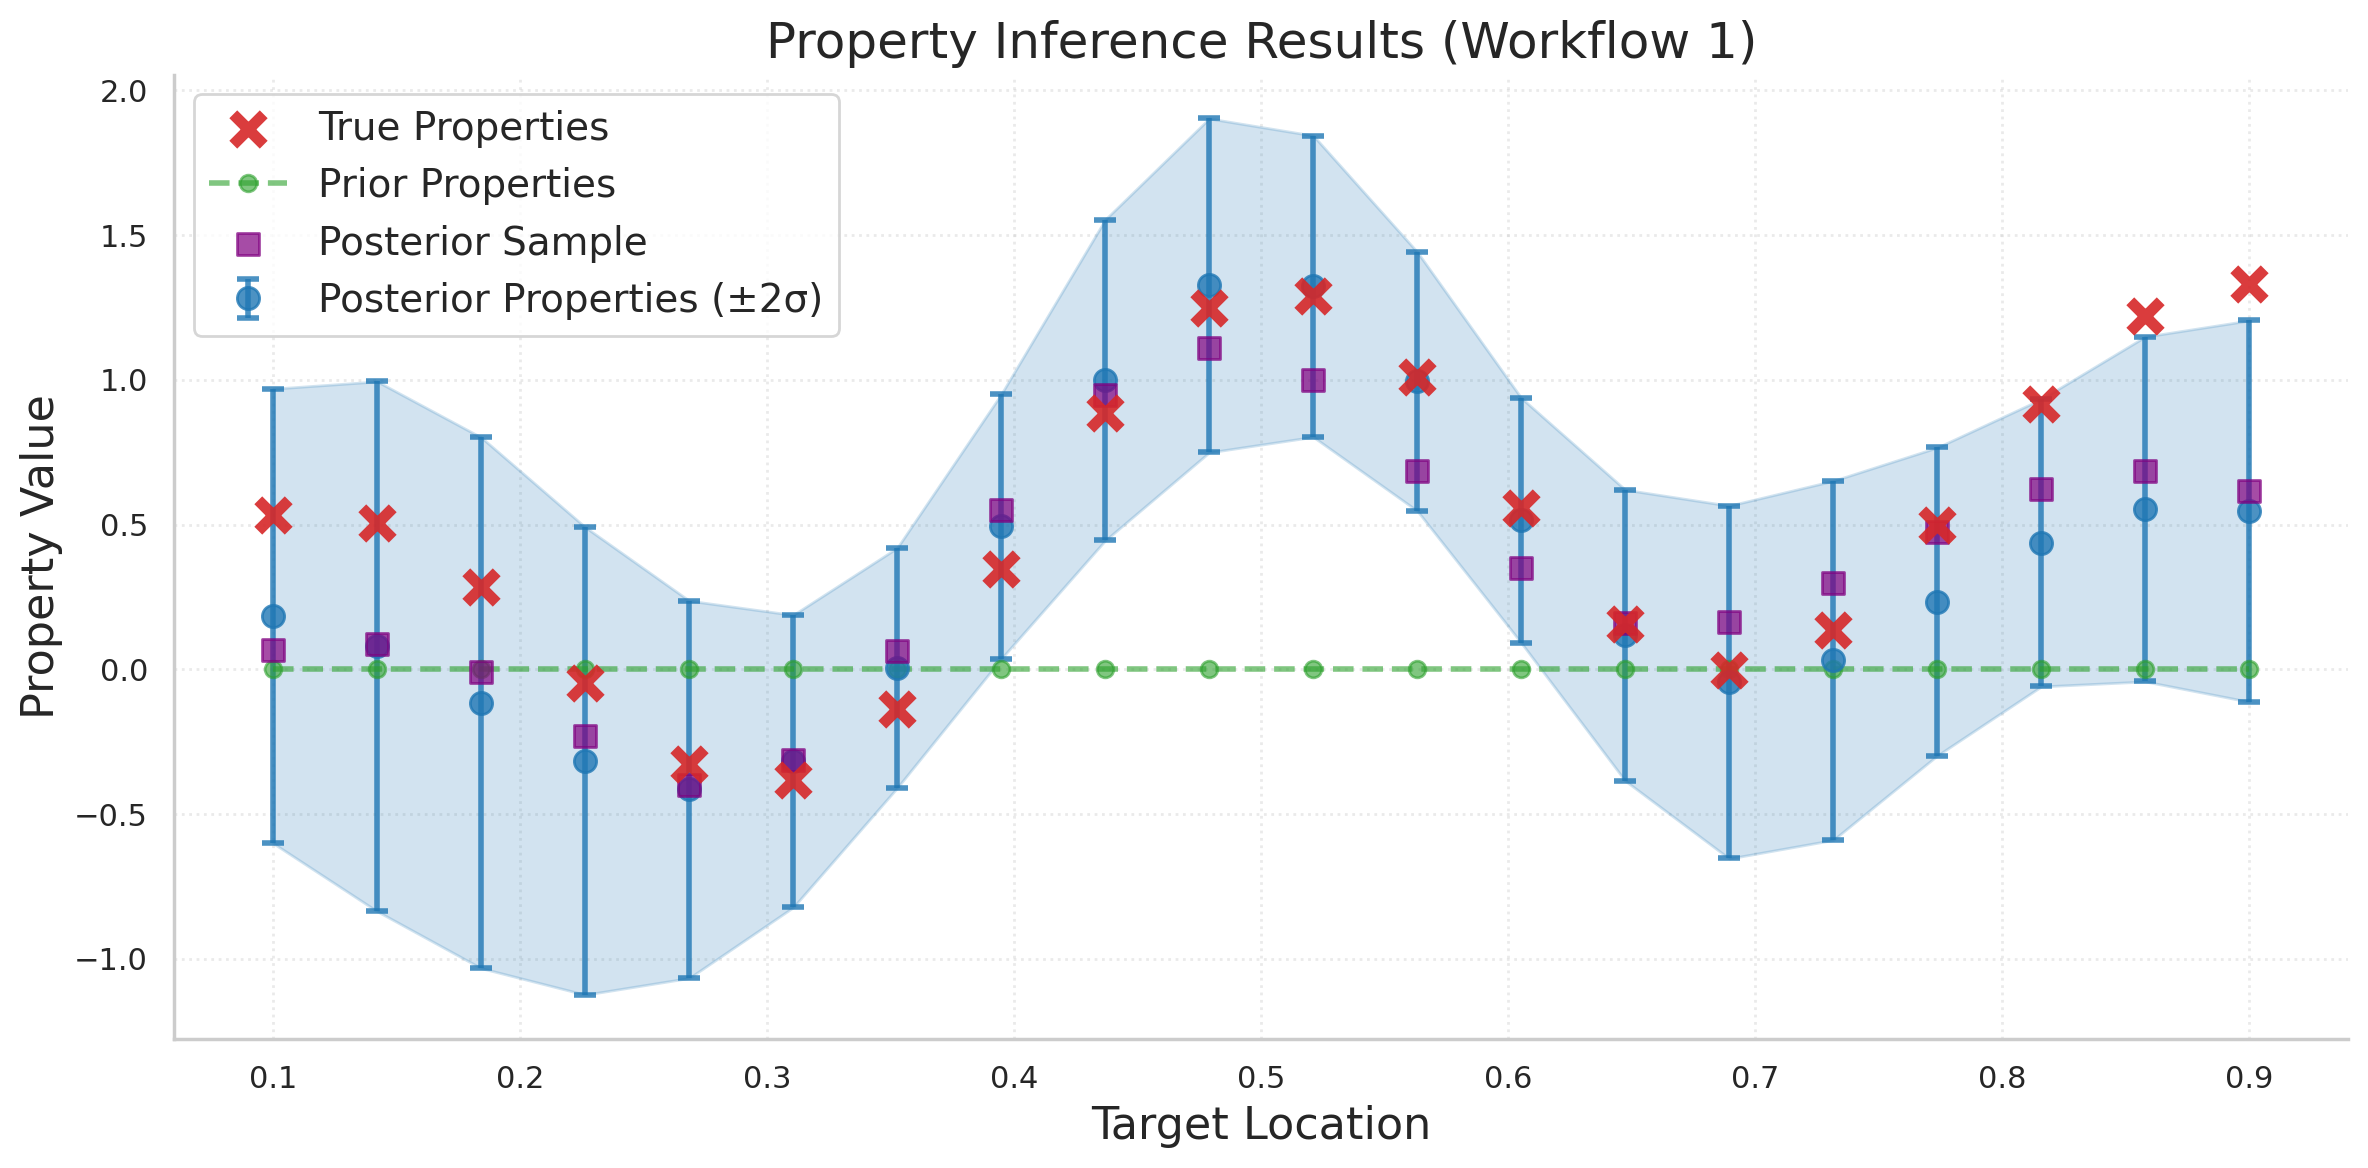


FINAL RESULTS SUMMARY
Workflow: 1 (via model posterior)
Properties successfully inferred: 18/20 (90.0%)
Mean absolute error: 0.2275
RMS error: 0.3151
Max error: 0.7852
Average uncertainty reduction: 76.9%


In [203]:
# Final property inference results
std_P_post = np.sqrt(np.diag(cov_P_matrix))

fig_title = "Property Inference Results"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 6), dpi=200)

# Property posterior with uncertainty
plt.errorbar(centers, p_tilde, yerr=2*std_P_post, fmt='o', color='tab:blue',
            alpha=0.8, capsize=4, capthick=2, markersize=8, linewidth=2,
            label='Posterior Properties (±2σ)')
plt.fill_between(centers, p_tilde - 2*std_P_post, p_tilde + 2*std_P_post,
                color='tab:blue', alpha=0.2)

# True properties
true_props = T(m_bar)
plt.scatter(centers, true_props, label='True Properties',
           color='tab:red', marker='x', s=120, alpha=0.9, linewidths=4, zorder=10)

# Prior for comparison
mean_prop_prior = T(M_prior.expectation)
plt.plot(centers, mean_prop_prior, 'o--', color='tab:green', alpha=0.6,
        markersize=6, linewidth=2, label='Prior Properties')

# Sample from posterior (only if we have full covariance)
if COMPUTE_MODEL_POSTERIOR:
    sampled_props_post = gaussian_P.sample()
    plt.scatter(centers, sampled_props_post, label='Posterior Sample',
               color='purple', marker='s', s=60, alpha=0.7, zorder=5)

workflow_label = "Workflow 1" if COMPUTE_MODEL_POSTERIOR else "Workflow 2 (Fast)"
plt.xlabel('Target Location', fontsize=16)
plt.ylabel('Property Value', fontsize=16)
plt.title(f'Property Inference Results ({workflow_label})', fontsize=18)
plt.legend(fontsize=14, loc='best')
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

# Quantitative assessment
property_errors = np.abs(p_tilde - true_props)
within_2sigma = np.sum(property_errors <= 2*std_P_post)

print("\n" + "="*50)
print("FINAL RESULTS SUMMARY")
print("="*50)
print(f"Workflow: {'1 (via model posterior)' if COMPUTE_MODEL_POSTERIOR else '2 (direct - fast)'}")
print(f"Properties successfully inferred: {within_2sigma}/{len(true_props)} ({100*within_2sigma/len(true_props):.1f}%)")
print(f"Mean absolute error: {np.mean(property_errors):.4f}")
print(f"RMS error: {np.sqrt(np.mean(property_errors**2)):.4f}")
print(f"Max error: {np.max(property_errors):.4f}")
print(f"Average uncertainty reduction: {100*(1 - np.mean(std_P_post)/np.mean(std_P)):.1f}%")
print("="*50)